# Problem Statement

**BUILD** a product recommendation system such that  
**GIVEN** a review data set which has information about the various products including user_sentiment and review_rating for various users
**WHEN** a particular user name is input to the recommener system  
**THEN** Top 5 products should be recommended to the concerned user.


In [4]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=False)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import chardet
import pathlib

In [6]:
# tweaking the column width so that we can read the entire attribute description
pd.get_option('display.max_colwidth') # getting the initial value

50

In [7]:
pd.set_option('display.max_colwidth', 150)

In [8]:
data_dir = pathlib.Path('/content/gdrive/MyDrive/Colab Notebooks/Sentiment Based Product Recommendation System')

In [9]:
data_dir.absolute()

PosixPath('/content/gdrive/MyDrive/Colab Notebooks/Sentiment Based Product Recommendation System')

In [10]:
data_dir.joinpath('Data+Attribute+Description.csv')

PosixPath('/content/gdrive/MyDrive/Colab Notebooks/Sentiment Based Product Recommendation System/Data+Attribute+Description.csv')

In [11]:
with open(data_dir.joinpath('Data+Attribute+Description.csv'), 'rb') as rawdata:
    result = chardet.detect(rawdata.read(10000))
print(result)

{'encoding': 'ISO-8859-1', 'confidence': 0.73, 'language': ''}


In [12]:
data_attributes = pd.read_csv(data_dir.joinpath('Data+Attribute+Description.csv'), encoding='ISO-8859-1')

In [13]:
data_attributes

,Attribute,Attribute Description
0,id,Uniques identity number to identify each unique review given by the user to a particular product in the dataset
1,brand,Name of the brand of the product to which user has given review and rating
2,categories,"Category of the product like household essentials, books, personal care products, medicines, cosmetic items, beauty products, electrical appliance..."
3,manufacturer,Name of the manufacturer of the product
4,name,Name of the product to which user has added review or rating
5,reviews_date,Date on which the review has been added by the user
6,reviews_didPurchase,Whether a particular user has purchased the product or not
7,reviews_doRecommend,Whether a particular user has recommended the product or not
8,reviews_rating,Rating given by the user to a particular product
9,reviews_text,Review given by the user to a particular product


Let's go through various features available to us and contemplate upon them keeping in mind our problem statement.  
  
1. `id` - this is a unique id for review dataset just like a primary key in a database table, if we think of reviews dataset as some sort of table. This should not add any value to our analysis. Let's see if we can drop it.  
2. `brand` - this is an important feature as it would uniquely identify what product brand to recomment.
3. `categories` - this actually tells us what sort of products a particular brand deals with. Ideally there should be a unique one to one mapping between a brand and its category information.
4. `manufacturer` - self-explanatory by its name, but the crucial thing is does it add any value or is it redundant information as similar information already supplied by `brand`? Let's see if we can drop it too.
5. `name` - product's name for which review exist. This is what we will use to recommend to the user
6. `reviews_date` - it may indicate on the reliability of reviews. If recent reviews are bad then old reviews then a user may rely more on the recent reviews.
7. `reviews_didPurchase` - should matter as reviews where actual purchase did not happen should be ignored, they could have been done out of business competiion
8. `reviews_doRecommend` - should matter as if the product recommended by user must have been rated positively, we can analyse further on it
9. `reviews_rating` - this is the number between 1 to 5 which would actually be used to calculate average review rating for a given product and make decision
10. `reviews_text` - this will be used to detect the sentiment of the review
11. `reviews_title` - this may not be of that importance as it may not necessarily be indicative of the user sentiment, but that is dicey case, in order to be on safe side we will merge it along with review_text
12. `reviews_userCity` - irrelevant, problem statement is about recommending products based on review rating, location should not be a concern
13. `reviews_userProvince` - irrelevant, same reason as above
14. `user_sentiment` - overall sentiment given to us, this could also server as the truth lable for testing our sentiment analysis classification model

**Importing reviews dataset**

In [14]:
review_dataset = pd.read_csv(data_dir.joinpath('sample30.csv'))
review_dataset.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Movie Bundles & Collections,CDs & Vinyl,Rap & Hip-Hop,Bass,Music on CD or Vinyl,Rap,Hip-Hop,Mainstream...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it ...,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part of a promotion.,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,"I read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it didn't even ...",Disappointed,NaN,NaN,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel caused irritation and it felt like it was burning my skin. I wouldn't recommend this gel.,Irritation,NaN,NaN,walker557,Negative


## 1. Exploratory data analysis

In [15]:
# checking the shape and size of review_dataset
review_dataset.shape

(30000, 15)

In [16]:
# checking if additional columns are there beside mentioned in data attributes
review_dataset.columns

Index(['id', 'brand', 'categories', 'manufacturer', 'name', 'reviews_date',
       'reviews_didPurchase', 'reviews_doRecommend', 'reviews_rating',
       'reviews_text', 'reviews_title', 'reviews_userCity',
       'reviews_userProvince', 'reviews_username', 'user_sentiment'],
      dtype='object')

> #### we can see that all the columns are mapped

In [17]:
review_dataset.name.value_counts().rename_axis('product_name').reset_index(name='count')

,product_name,count
0,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,8545
1,Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,3325
2,Clorox Disinfecting Bathroom Cleaner,2039
3,L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz,1186
4,Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd),1143
...,...,...
266,Craft Punch Giga Scallop Circle 45 24687534 To 334,1
267,High-Dome Floor Door Stop,1
268,Greyson Vintage Industrial Occasional Cocktail Coffee Table - Antique Bronze - Baxton Studio,1
269,Udi's Pepperoni Pizza,1


#### Checking the freequency of product occurence in data set

In [18]:
product_freequency = pd.DataFrame(data=review_dataset.name.value_counts().rename_axis('product_name').reset_index(name='count'), columns=['product_name', 'count'])
product_freequency

,product_name,count
0,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,8545
1,Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,3325
2,Clorox Disinfecting Bathroom Cleaner,2039
3,L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz,1186
4,Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd),1143
...,...,...
266,Craft Punch Giga Scallop Circle 45 24687534 To 334,1
267,High-Dome Floor Door Stop,1
268,Greyson Vintage Industrial Occasional Cocktail Coffee Table - Antique Bronze - Baxton Studio,1
269,Udi's Pepperoni Pizza,1


In [19]:
product_freequency['freequency'] = round(product_freequency['count']/sum(product_freequency['count'])*100, 2)

In [20]:
product_freequency.describe()

,count,freequency
count,271.000000,271.000000
mean,110.701107,0.368635
std,586.875174,1.956075
min,1.000000,0.000000
25%,3.000000,0.010000
50%,8.000000,0.030000
75%,29.000000,0.100000
max,8545.000000,28.480000


> #### we can cleary see that there are certain products which are very much pronounced and then their are some which have very low count or freequency
> ##### min is 1, upto 25% we have 3 as count, till 50% count reaches 8, it is between 50-75% that count reaches 29 than means  it is that 25$ chunk of data which reaches around 29. Max value is 8545 - this is clearly a case of outlier contribution

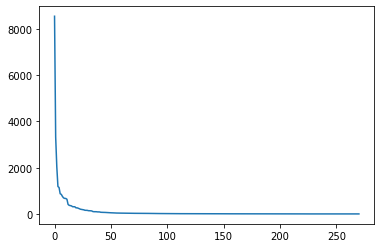

In [21]:
# Let us draw a line plot of count
product_freequency['count'].plot.line()
plt.show()

> #### We can clearly see that count sharply reduces from 8000 to near about may be 2 or 3 and then stays stable near that value. again it is clear that there are outliers in terms of products bought

#### Let us draw the box plot for this one

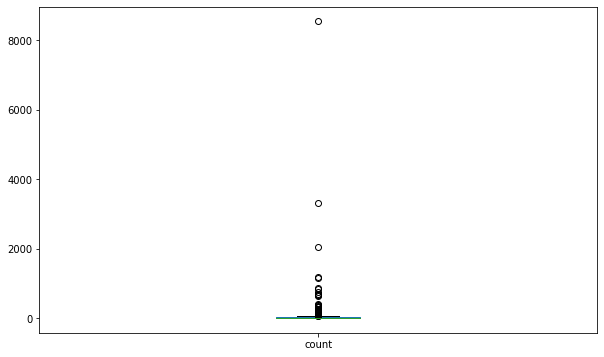

In [22]:
plt.figure(figsize=(10,6))
product_freequency['count'].plot.box()
plt.show()

#### Let us check the how many users are involved

In [23]:
# let us get a unique count of users
len(pd.unique(review_dataset.reviews_username))

24915

> #### We know that we have 30000 reviews out of which we are able get 24915 users. This implies that some users have more than one reviews

In [24]:
review_dataset.groupby('reviews_username').count()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,user_sentiment
reviews_username,,,,,,,,,,,,,,
00dog3,1,1,1,1,1,1,1,1,1,1,1,0,0,1
00sab00,2,2,2,2,2,2,0,2,2,2,2,0,0,2
01impala,1,1,1,1,1,1,0,1,1,1,1,0,0,1
02dakota,1,1,1,1,1,1,0,1,1,1,1,0,0,1
02deuce,1,1,1,1,1,1,0,1,1,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zxcsdfd,2,2,2,2,2,2,1,2,2,2,2,0,0,2
zxjki,1,1,1,1,1,1,1,1,1,1,1,0,0,1
zyiah4,1,1,1,1,1,1,1,1,1,1,1,0,0,1


#### Let us check the unique number of products

In [25]:
# let us check the number of overall unique products that have been bought
len(pd.unique(review_dataset.name))

271

#### Let us check the unique number of categories

In [26]:
# let us check the number of categories of products that exist overall
len(pd.unique(review_dataset.reviews_username))

24915

In [27]:
# let us check the number of users that exist overall
len(pd.unique(review_dataset.categories))

270

In [28]:
# checking the number of review words length for review text column

review_text_count = review_dataset.reviews_text.str.split().apply(len)

In [29]:
review_text_count

0         41
1         11
2          2
3        124
4         25
        ... 
29995     47
29996     22
29997     48
29998     63
29999     49
Name: reviews_text, Length: 30000, dtype: int64

In [30]:
max(review_text_count)

1010

#### Let us check the unique number of brands

In [31]:
# let us do something similar for brand as well
len(pd.unique(review_dataset.brand))

214

### Categories is going to be a very important column to deal with let us make a different dataframe out of it to analyze it

In [32]:
# let us create category dataframe first for easy analysis
df_category = pd.DataFrame(data=pd.unique(review_dataset.categories), columns=['category'])

#### Next thing should be to extract various tags out of categories column as we can see that categories are filled with many tags

In [33]:
# getting the various tags in one of the category row
set([str.strip(x) for x  in df_category.loc[0].get(0).split(',')])

{'Bass',
 'CDs & Vinyl',
 'Hip-Hop',
 'Mainstream Rap',
 'Movie Bundles & Collections',
 'Movies',
 'Movies & TV',
 'Music',
 'Music & Books',
 'Music on CD or Vinyl',
 'Pop Rap',
 'R&b',
 'Rap',
 'Rap & Hip-Hop'}

In [34]:
# let us write a function which will take row index and return a set of category tags
def get_set_of_tags(row_number, column_number, dataframe):
    return set([str.strip(x) for x  in dataframe.loc[row_number].get(column_number).split(',')])

In [35]:
get_set_of_tags(0, 0, df_category)

{'Bass',
 'CDs & Vinyl',
 'Hip-Hop',
 'Mainstream Rap',
 'Movie Bundles & Collections',
 'Movies',
 'Movies & TV',
 'Music',
 'Music & Books',
 'Music on CD or Vinyl',
 'Pop Rap',
 'R&b',
 'Rap',
 'Rap & Hip-Hop'}

In [36]:
# experimenting with various sets as we have to bring in the values together in one set
set_1 = get_set_of_tags(0, 0, df_category)

In [37]:
set_2 = get_set_of_tags(1, 0, df_category)

In [38]:
# let us check their union
list(set_1.union(set_2))

['Bass',
 'Rice Cakes',
 'Music',
 'Rap & Hip-Hop',
 'Rap',
 'R&b',
 'Movies',
 'Music & Books',
 'Food',
 'Cakes',
 'Crackers',
 'Mainstream Rap',
 'CDs & Vinyl',
 'Pop Rap',
 'Movies & TV',
 'Packaged Foods',
 'Cookies & Chips',
 'Music on CD or Vinyl',
 'Snacks',
 'Movie Bundles & Collections',
 'Hip-Hop']

In [39]:
# creating a set and then adding all the possible tags in that set to know what all category tags exist overall
category_tags = set()
# df_category.shape[0]
for i in range(df_category.shape[0]):
    global category_tags
    category_tags = category_tags.union(get_set_of_tags(i, 0, df_category))

In [40]:
category_tags = list(category_tags)

In [41]:
df_category_tags = pd.DataFrame(data=category_tags, columns = ['category_tags'])

In [42]:
df_category_tags

,category_tags
0,
1,Boys' Room Furniture
2,Canned Meals
3,Disney Junior
4,Extracts & Colorings
...,...
1331,Cleaning
1332,Fishing Tackle Boxes
1333,Bathroom Faucets and Shower Heads
1334,Stoves


#### Let us export the category_tags to csv 

In [43]:
df_category_tags.to_csv("category_tags.csv", index=False)

### Let us try to analyse co-relation between user rating and its sentiment

In [44]:
df_rating_sentiment = review_dataset[['reviews_rating', 'user_sentiment']]

In [45]:
df_rating_sentiment['user_sentiment'] = df_rating_sentiment['user_sentiment'].apply(lambda x: 0 if x=='Negative' else 1)

In [46]:
# the above transformation will help us calulate the average review rating that distinguished between a POSITIVE and NEGATIVE sentiment
mean_positive_rating = df_rating_sentiment[df_rating_sentiment.user_sentiment==1].reviews_rating.mean()
print("mean rating with positive user sentiment = {}".format(mean_positive_rating ))

mean rating with positive user sentiment = 4.560394998685841


In [47]:
mean_positive_rating = df_rating_sentiment[df_rating_sentiment.user_sentiment==0].reviews_rating.mean()
print("mean rating with positive user sentiment = {}".format(mean_positive_rating ))

mean rating with positive user sentiment = 3.871992871992872


#### Box plot for NEGATIVE SENTIMENT RATINGS

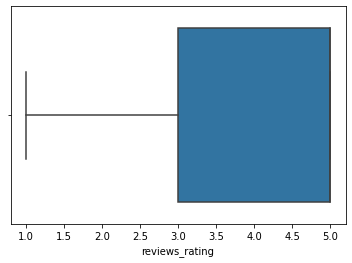

In [48]:
sns.boxplot(df_rating_sentiment[df_rating_sentiment.user_sentiment==0].reviews_rating)
plt.show()

#### Box plot for POSITIVE SENTIMENT RATINGS

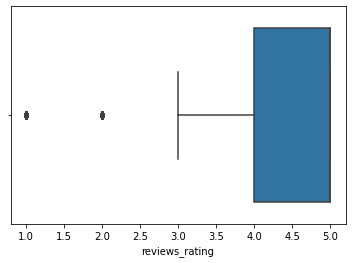

In [49]:
sns.boxplot(df_rating_sentiment[df_rating_sentiment.user_sentiment==1].reviews_rating)
plt.show()

> #### Clearly we can see that mean ratings differed for POSITIVE and NEGATIVE ratings
1. for POSITIVE it is around `4.5`
2. where as for NEGATIVE it is around `3.8`
3. also the box plots are drawn which tell that there is No POSITIVE sentiment associated with a rating less than `4.0` 
4. but in case of NEGATIVE rating range goes from `3` to `5` - that simply means there is data which was given higher rating but still it got a review with a negative sentiment

#### Let us try to draw a scatter plot between both and see if we can see any pattern

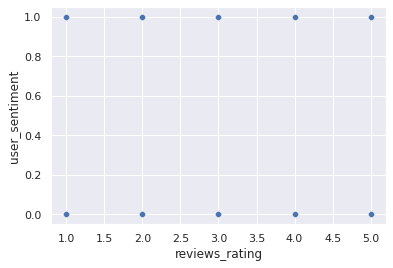

In [50]:
sns.set(font_scale=1)
sns.scatterplot(x="reviews_rating", y="user_sentiment", data=df_rating_sentiment)
plt.show()

> #### Clearly all the ratings are fair distrbuted amongst both the sentiments.

#### Let us see the rating distribution over all the products

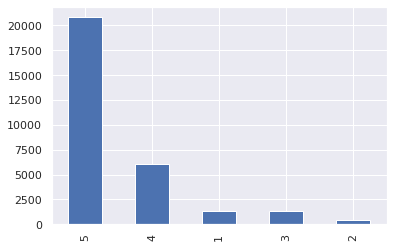

In [51]:
df_rating_sentiment.reviews_rating.value_counts().plot.bar()
plt.show()

> #### 20000 products have 5 ratings and around 6000 have 4 ratings. That means out of 30000 products around less than 4000 products have ratings below 4. That tells that overall experiene of the e-commerce website is good.

In [52]:
df_product_reviews = review_dataset[['name', 'user_sentiment', 'reviews_didPurchase', 'reviews_doRecommend', 'reviews_rating']]
df_product_reviews

,name,user_sentiment,reviews_didPurchase,reviews_doRecommend,reviews_rating
0,Pink Friday: Roman Reloaded Re-Up (w/dvd),Positive,NaN,NaN,5
1,Lundberg Organic Cinnamon Toast Rice Cakes,Positive,True,NaN,5
2,Lundberg Organic Cinnamon Toast Rice Cakes,Positive,True,NaN,5
3,K-Y Love Sensuality Pleasure Gel,Negative,False,False,1
4,K-Y Love Sensuality Pleasure Gel,Negative,False,False,1
...,...,...,...,...,...
29995,L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz,Positive,False,True,5
29996,L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz,Positive,False,True,5
29997,L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz,Positive,False,True,5
29998,L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz,Positive,False,True,5


In [53]:
df_product_reviews['user_sentiment'] = df_product_reviews['user_sentiment'].apply(lambda x: 0 if x=='Negative' else 1)
df_product_reviews['reviews_doRecommend'] = df_product_reviews['reviews_doRecommend'].apply(lambda x: 0 if x==False else 1)
df_product_reviews['reviews_didPurchase'] = df_product_reviews['reviews_didPurchase'].apply(lambda x: 0 if x==False else 1)

In [54]:
df_product_user_profile = df_product_reviews.groupby('name').mean()
df_product_user_profile

,user_sentiment,reviews_didPurchase,reviews_doRecommend,reviews_rating
name,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,0.500000,0.666667,1.000000,4.166667
100:Complete First Season (blu-Ray),0.935252,0.978417,0.992806,4.712230
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,0.250000,1.000000,1.000000,5.000000
"2x Ultra Era with Oxi Booster, 50fl oz",1.000000,0.200000,1.000000,4.800000
"42 Dual Drop Leaf Table with 2 Madrid Chairs""",1.000000,1.000000,1.000000,5.000000
...,...,...,...,...
Weleda Everon Lip Balm,1.000000,1.000000,1.000000,4.625000
Wilton Black Dots Standard Baking Cups,1.000000,0.000000,1.000000,5.000000
Windex Original Glass Cleaner Refill 67.6oz (2 Liter),0.798851,0.152299,0.813218,4.129310


In [55]:
df_product_user_profile.describe()

,user_sentiment,reviews_didPurchase,reviews_doRecommend,reviews_rating
count,271.000000,271.000000,271.000000,271.000000
mean,0.843199,0.720639,0.950004,4.374025
std,0.218596,0.342697,0.098786,0.749857
min,0.000000,0.000000,0.411255,1.000000
25%,0.800000,0.465476,0.936141,4.127155
50%,0.904506,0.935484,1.000000,4.600000
75%,1.000000,1.000000,1.000000,4.909091
max,1.000000,1.000000,1.000000,5.000000


#### Let us try to draw a jointplot between `reviews_rating` and `user_sentiment`

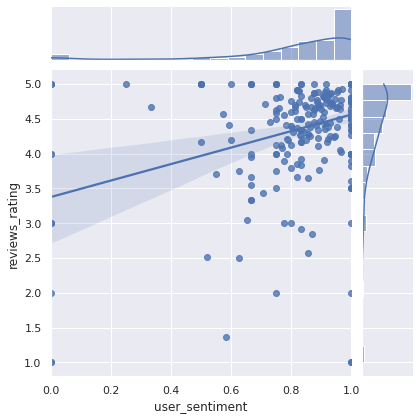

In [56]:
sns.jointplot(x='user_sentiment', y='reviews_rating', data=df_product_user_profile, kind='reg')
plt.show()

> #### This is sort of expected. Exlcuding certain exceptions, general trend is `higher user sentiment scores` and `higer user ratings` are concentrated in the right most corner.

#### Also let us check correlation between review reviews_doRecommend and reviews_rating

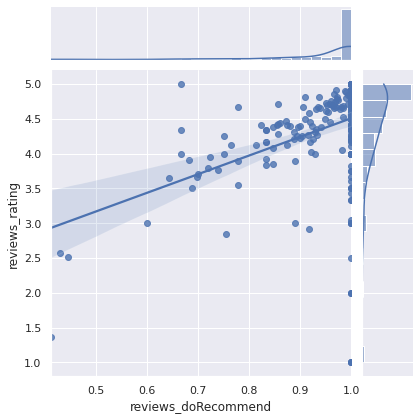

In [57]:
sns.jointplot(x='reviews_doRecommend', y='reviews_rating', data=df_product_user_profile, kind='reg')
plt.show()

> #### Here we know that the floating point value for reivews_rating happened because we have taken mean. Increasing value of this mean along with the rating of the product simply implies that chances of a product being recommended increases with its review rating.
> There is a regression line fitting in the scatter plot and upper right corner is densely populated.

#### Let us draw the pairplot to get a wholistic idea about the correlation amongst various feature fields

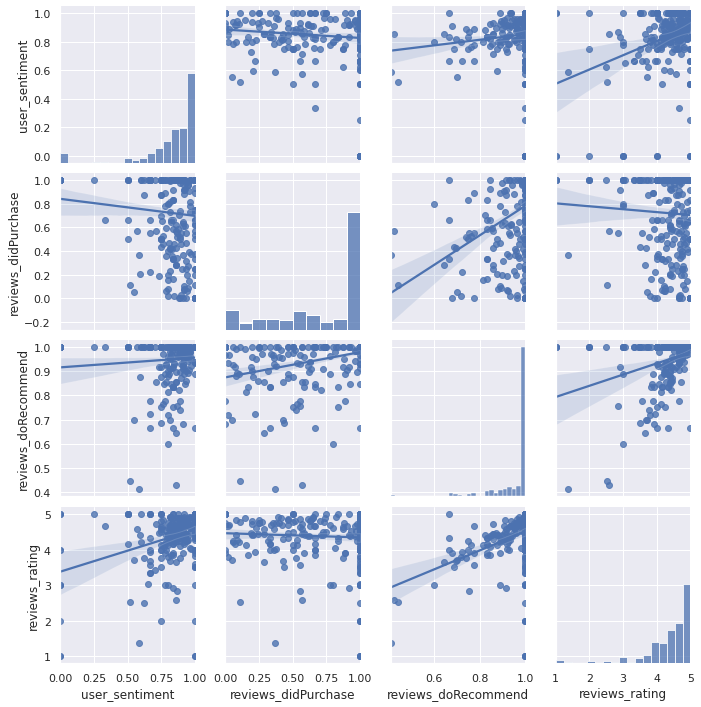

In [58]:
sns.pairplot(data=df_product_user_profile, kind='reg')

#### Let us try to analyze the mapping between `categories` and `names` as an attempt to check if there are multiple products mapped to one category

In [59]:
df_category_products = review_dataset[['categories', 'name']]

In [60]:
df_category_products.describe()

,categories,name
count,30000,30000
unique,270,271
top,"Household Essentials,Cleaning Supplies,Kitchen Cleaners,Cleaning Wipes,All-Purpose Cleaners,Health & Household,Household Supplies,Household Cleani...",Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total
freq,8545,8545


In [61]:
df_category_products_unq = df_category_products.drop_duplicates()

In [62]:
df_category_products_unq.groupby('categories').count().query('name > 1')

,name
categories,
"Personal Care,Makeup,Lipstick, Lip Gloss, & Lip Balm,Lipstick,Beauty,Lips",2


> #### Basically there are more than one products which are mapped to single categories. But mostly we can say that in the provided data set category and name are almost one to one mapped

In [63]:
df_user_to_product_profile =  review_dataset[['reviews_username', 'categories', 'name', 'reviews_didPurchase', 'reviews_doRecommend']]

In [64]:
df_user_to_product_profile

,reviews_username,categories,name,reviews_didPurchase,reviews_doRecommend
0,joshua,"Movies, Music & Books,Music,R&b,Movies & TV,Movie Bundles & Collections,CDs & Vinyl,Rap & Hip-Hop,Bass,Music on CD or Vinyl,Rap,Hip-Hop,Mainstream...",Pink Friday: Roman Reloaded Re-Up (w/dvd),NaN,NaN
1,dorothy w,"Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes",Lundberg Organic Cinnamon Toast Rice Cakes,True,NaN
2,dorothy w,"Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes",Lundberg Organic Cinnamon Toast Rice Cakes,True,NaN
3,rebecca,"Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants",K-Y Love Sensuality Pleasure Gel,False,False
4,walker557,"Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants",K-Y Love Sensuality Pleasure Gel,False,False
...,...,...,...,...,...
29995,laurasnchz,"Beauty,Hair Care,Shampoo & Conditioner,Holiday Shop,Christmas,Featured Brands,Health & Beauty,L'oreal,Personal Care,Hair Treatments,Conditioner",L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz,False,True
29996,scarlepadilla,"Beauty,Hair Care,Shampoo & Conditioner,Holiday Shop,Christmas,Featured Brands,Health & Beauty,L'oreal,Personal Care,Hair Treatments,Conditioner",L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz,False,True
29997,liviasuexo,"Beauty,Hair Care,Shampoo & Conditioner,Holiday Shop,Christmas,Featured Brands,Health & Beauty,L'oreal,Personal Care,Hair Treatments,Conditioner",L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz,False,True
29998,ktreed95,"Beauty,Hair Care,Shampoo & Conditioner,Holiday Shop,Christmas,Featured Brands,Health & Beauty,L'oreal,Personal Care,Hair Treatments,Conditioner",L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz,False,True


In [65]:
review_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    30000 non-null  object
 1   brand                 30000 non-null  object
 2   categories            30000 non-null  object
 3   manufacturer          29859 non-null  object
 4   name                  30000 non-null  object
 5   reviews_date          29954 non-null  object
 6   reviews_didPurchase   15932 non-null  object
 7   reviews_doRecommend   27430 non-null  object
 8   reviews_rating        30000 non-null  int64 
 9   reviews_text          30000 non-null  object
 10  reviews_title         29810 non-null  object
 11  reviews_userCity      1929 non-null   object
 12  reviews_userProvince  170 non-null    object
 13  reviews_username      29937 non-null  object
 14  user_sentiment        29999 non-null  object
dtypes: int64(1), object(14)
memory usage

### 2. Data cleaning

#### First of all let us drop below columns as they are not significant for our problem statement


1.   `id` - this is just unique identifier column
2.   `reviews_date` - there is no additional relevant features such as product_status telling if product is active or not, and if older products need to be recommended, therefore it can be dropped
3. `reviews_title` - for our sentiment analysis we can use the reviews_text column as this column would offer sentiment information it is advisable to merge it into review_text and get rid of one extra feature. That way we would get hold of important text indicative of user sentiment as the feature includes words like `must`, `recommend`, `miracle` etc 
4. `reviews_userCity` - we are not considerting city as some constraint while offering product recommendations to the user, so this will be dropped.
5. `reviews_userProvince` - same logic applies here. this is irrelevant as it can be safely assumed e-commerce has ability to deliver in all locations and problem statement is not focussed upon recomnending based upon location of the user. 
6.  `categories` - if we think from our problem statement prespective, this is actually irrelevant. Peer users can be created by the common items user bought. Items can be grouped on the basis of users who bought them. So we can drop this column


In [66]:
# let us first copy the data in master table
df_master = review_dataset.copy()

In [67]:
df_master.head(2)

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Movie Bundles & Collections,CDs & Vinyl,Rap & Hip-Hop,Bass,Music on CD or Vinyl,Rap,Hip-Hop,Mainstream...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it ...,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part of a promotion.,Good,NaN,NaN,dorothy w,Positive


In [68]:
df_master.columns

Index(['id', 'brand', 'categories', 'manufacturer', 'name', 'reviews_date',
       'reviews_didPurchase', 'reviews_doRecommend', 'reviews_rating',
       'reviews_text', 'reviews_title', 'reviews_userCity',
       'reviews_userProvince', 'reviews_username', 'user_sentiment'],
      dtype='object')

In [69]:
# let us merge all text of review title to review text
# df_master['reviews_title']
df_master['reviews_title'] + ' ' + df_master['reviews_text'] 

0        Just Awesome i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gy...
1                                                                                          Good Good flavor. This review was collected as part of a promotion.
2                                                                                                                                            Good Good flavor.
3        Disappointed I read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it...
4              Irritation My husband bought this gel for us. The gel caused irritation and it felt like it was burning my skin. I wouldn't recommend this gel.
                                                                                 ...                                                                          
29995    Softness!! I got this conditioner wit

We can see that when we perform above exercise many strong sentiment indicative words are added to review text such as . Hence it should turn out to be a good decision.

In [70]:
# performing the merge, later we can drop the reviews_title
df_master['reviews_text'] = df_master['reviews_title'] + ' ' + df_master['reviews_text'] 

In [71]:
# let us now drop the columns
df_master.drop(columns=['id','reviews_date',
       'reviews_title', 'reviews_userCity',
       'reviews_userProvince', 'categories'], inplace=True)

In [72]:
df_master.columns

Index(['brand', 'manufacturer', 'name', 'reviews_didPurchase',
       'reviews_doRecommend', 'reviews_rating', 'reviews_text',
       'reviews_username', 'user_sentiment'],
      dtype='object')

#### Now let us check what else we can drop
1. `brand` - this holds the information of the brand what if this information is redundant and already represented in the name of the product and manufacturer of the product
2. `manufacturer` - similar logic applies here as above
3. `name` - this is the actual name of the product which is going to serve unique identifier of the product too. We can see that name is very descriptive and holds all the relevant information such as brand and manufacturer.  

We can check what columns can be dropped. Let's analyse!

In [73]:
df_prod_id_check = df_master[['brand', 'manufacturer', 'name']]
df_prod_id_check.head()

,brand,manufacturer,name
0,Universal Music,Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd)
1,Lundberg,Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes
2,Lundberg,Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes
3,K-Y,K-Y,K-Y Love Sensuality Pleasure Gel
4,K-Y,K-Y,K-Y Love Sensuality Pleasure Gel


In [74]:
df_prod_id_check.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   brand         30000 non-null  object
 1   manufacturer  29859 non-null  object
 2   name          30000 non-null  object
dtypes: object(3)
memory usage: 703.2+ KB


In [75]:
df_prod_id_check[['brand_in_manfufact']] = df_prod_id_check.apply(lambda x: (x['brand'] in str(x['manufacturer'])), axis=1)

In [76]:
df_prod_id_check.head()

,brand,manufacturer,name,brand_in_manfufact
0,Universal Music,Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),True
1,Lundberg,Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,True
2,Lundberg,Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,True
3,K-Y,K-Y,K-Y Love Sensuality Pleasure Gel,True
4,K-Y,K-Y,K-Y Love Sensuality Pleasure Gel,True


In [77]:
df_prod_id_check.brand_in_manfufact.value_counts()

True     16642
False    13358
Name: brand_in_manfufact, dtype: int64

In [78]:
percentage = round(13358/(16642+13358)*100,2)
print("Total {}%  of rows where brand does not appear in the manufacturer".format(percentage))

Total 44.53%  of rows where brand does not appear in the manufacturer


**Let's check few such values**

In [79]:
df_prod_id_check[df_prod_id_check.brand_in_manfufact==False]

,brand,manufacturer,name,brand_in_manfufact
36,AMBI,FLEMING & CO,Ambi Complexion Cleansing Bar,False
37,AMBI,FLEMING & CO,Ambi Complexion Cleansing Bar,False
38,AMBI,FLEMING & CO,Ambi Complexion Cleansing Bar,False
39,AMBI,FLEMING & CO,Ambi Complexion Cleansing Bar,False
54,Olay,P&G,Olay Regenerist Deep Hydration Regenerating Cream,False
...,...,...,...,...
28809,Mrs. Meyer's,Mrs. Meyers,Mrs. Meyer's Lemon Verbena Surface Scrub,False
28810,Mrs. Meyer's,Mrs. Meyers,Mrs. Meyer's Lemon Verbena Surface Scrub,False
28811,Mrs. Meyer's,Mrs. Meyers,Mrs. Meyer's Lemon Verbena Surface Scrub,False
28812,Mrs. Meyer's,Mrs. Meyers,Mrs. Meyer's Lemon Verbena Surface Scrub,False


> #### We can see that manufacturer has text info common as brand text info. 
1. here `we can actually drop the manufactuer` column because from a business point of view a customer would rarely be concerned with manufacturer and brand name should be sufficient. 
2. But lets check for brand text overlap with name of the product
3. some manufacturer has floating point value `120, 1200` mostly this must be some case of data corruption. It is wise to drop the manufacutere column

#### Let us check for the brand in name now

In [80]:
df_prod_id_check[['brand_in_name']] = df_prod_id_check.apply(lambda x: (x['brand'].lower() in str(x['name']).lower()), axis=1)

In [81]:
df_prod_id_check.brand_in_name.value_counts()

True     19841
False    10159
Name: brand_in_name, dtype: int64

In [82]:
percentage = round(10159/(19841+10159)*100,2)
print("Total {}%  of rows where brand does not appear in the name".format(percentage))

Total 33.86%  of rows where brand does not appear in the name


**Let's check few such values**

In [83]:
df_prod_id_check[df_prod_id_check.brand_in_name==False]

,brand,manufacturer,name,brand_in_manfufact,brand_in_name
0,Universal Music,Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),True,False
1161,Disney,Disney/Pixar,Cars Toon: Mater's Tall Tales,True,False
1162,Disney,Disney/Pixar,Cars Toon: Mater's Tall Tales,True,False
1163,Disney,Disney/Pixar,Cars Toon: Mater's Tall Tales,True,False
1164,Disney,Disney/Pixar,Cars Toon: Mater's Tall Tales,True,False
...,...,...,...,...,...
29995,L'oreal Paris,L'oreal Paris,L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz,True,False
29996,L'oreal Paris,L'oreal Paris,L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz,True,False
29997,L'oreal Paris,L'oreal Paris,L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz,True,False
29998,L'oreal Paris,L'oreal Paris,L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz,True,False


> #### We can see that 
1. name of the product does not necessarily contain the brand information. 
2. so what we can do is append brand to name column, making it more descriptive and dropping the brand column all together.
3. also there are some values such `L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz` in which `L'or233al` seems to be a typo

In [84]:
import re
x = df_prod_id_check[df_prod_id_check['name'].apply(lambda x: len(re.findall('[0-9]', x))>0 )]
pd.unique(x['name'])

array(["Johnson's Baby Bubble Bath and Wash, 15oz",
       'Windex Original Glass Cleaner Refill 67.6oz (2 Liter)',
       'Heinz Tomato Ketchup, 38oz',
       'Kind Dark Chocolate Chunk Gluten Free Granola Bars - 5 Count',
       'Pantene Color Preserve Volume Shampoo, 25.4oz',
       'Aussie Aussome Volume Shampoo, 13.5 Oz',
       'Finish Quantum Dishwasher Detergent, Lemon Sparkle Scent, 45 Count',
       'Disney174 Jake And The Neverland Pirates 4 Piece Bedding Set - Toddler',
       'Craft Punch Giga Scallop Circle 45 24687534 To 334',
       'Neutrogena Wet Skin Sunscreen Spray Broad Spectrum SPF 50, 5oz',
       "Meguiar's Deep Crystal Car Wash 64-Oz.",
       'Cetaphil Gentle Skin Cleanser, 2oz',
       'Bumble Bee Solid White Albacore In Water - 5 Oz',
       'Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee',
       'Alberto VO5 Salon Series Smooth Plus Sleek Shampoo',
       'My Big Fat Greek Wedding 2 (blu-Ray + Dvd + 

> #### We can see that there are many products which have numeric digits. Loreal case seems to be a typo one. Correcting all such possible cases would be an overkill and unwise, therefore lets append brand column to name and drop the brand and name column

In [85]:
# dropping manufacturer column
df_master.drop('manufacturer', axis=1, inplace=True)

In [86]:
'manufacturer' in df_master.columns

False

In [87]:
df_master.columns

Index(['brand', 'name', 'reviews_didPurchase', 'reviews_doRecommend',
       'reviews_rating', 'reviews_text', 'reviews_username', 'user_sentiment'],
      dtype='object')

In [88]:
# now appending brand to name with a pipleline operator and then dropping bran column
df_master['name_brand'] = df_master.apply(lambda x: x['name'] + ('|') + x['brand'], axis=1)
# df_master.name_brand

In [89]:
# now dropping name column too as it redundant
df_master.drop('name', axis=1, inplace=True)

In [90]:
# dropping the brand column too as it is redundant
df_master.drop('brand', axis=1, inplace=True)

In [91]:
# now checking what all columns exist
df_master.columns

Index(['reviews_didPurchase', 'reviews_doRecommend', 'reviews_rating',
       'reviews_text', 'reviews_username', 'user_sentiment', 'name_brand'],
      dtype='object')

#### Let us perform data quality checks now and see what all need imputation or removal.

In [92]:
df_master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   reviews_didPurchase  15932 non-null  object
 1   reviews_doRecommend  27430 non-null  object
 2   reviews_rating       30000 non-null  int64 
 3   reviews_text         29810 non-null  object
 4   reviews_username     29937 non-null  object
 5   user_sentiment       29999 non-null  object
 6   name_brand           30000 non-null  object
dtypes: int64(1), object(6)
memory usage: 1.6+ MB


**We can observe below**


1.   name_brand, categories, reviews_rating, reviews_text have zero nulls as can be seen above
2.   reviews_didPurchase has overall around 50% null values, likely to be dropped
3.   reviews_doRecommend has around 10% null values which may need some imputation. We can do it on the basis of our initial EDA
4.   reviews_username has certain null values around 63 - no imputation would make sense here so we need to drop them first
5.   user_sentiment has only one null value - that would be the easiest to impute based on our EDA



In [93]:
# Let's drop the data where username is null
df_master[~df_master['reviews_username'].isna()] # finding the data where usernae is not NaN

,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_username,user_sentiment,name_brand
0,NaN,NaN,5,Just Awesome i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gy...,joshua,Positive,Pink Friday: Roman Reloaded Re-Up (w/dvd)|Universal Music
1,True,NaN,5,Good Good flavor. This review was collected as part of a promotion.,dorothy w,Positive,Lundberg Organic Cinnamon Toast Rice Cakes|Lundberg
2,True,NaN,5,Good Good flavor.,dorothy w,Positive,Lundberg Organic Cinnamon Toast Rice Cakes|Lundberg
3,False,False,1,"Disappointed I read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it...",rebecca,Negative,K-Y Love Sensuality Pleasure Gel|K-Y
4,False,False,1,Irritation My husband bought this gel for us. The gel caused irritation and it felt like it was burning my skin. I wouldn't recommend this gel.,walker557,Negative,K-Y Love Sensuality Pleasure Gel|K-Y
...,...,...,...,...,...,...,...
29995,False,True,5,"Softness!! I got this conditioner with Influenster to try it and im loving it so far, i have oily hair so i use it only in the ends of my hair and...",laurasnchz,Positive,L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz|L'oreal Paris
29996,False,True,5,"I love it I love it , I received this for review purposes from influenster and it leaves my hair feeling fresh and smelling great",scarlepadilla,Positive,L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz|L'oreal Paris
29997,False,True,5,Hair is so smooth after use First of all I love the smell of this product. After you wash your hair it is so smooth and easy to brush! I did recei...,liviasuexo,Positive,L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz|L'oreal Paris
29998,False,True,5,Perfect for my oily hair! I received this through Influenster and will never go back to anything else! I normally don't use conditioner because my...,ktreed95,Positive,L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz|L'oreal Paris


In [94]:
# we got 29937 rows in the output same in result of info function
# lets re-initialize our master data frame
df_master = df_master[~df_master['reviews_username'].isna()]

In [95]:
# now our dataframe should have 299937 rows and 8 columns
df_master.shape

(29937, 7)

In [96]:
# now let us drop the reviews_didPurchase columns as it has around 50% null values.
df_master.drop('reviews_didPurchase', axis=1, inplace=True)

**Now let us impute missing data**

In [97]:
# checking for user_sentiment as it has only one NaN value
df_master[df_master['user_sentiment'].isna()]

,reviews_doRecommend,reviews_rating,reviews_text,reviews_username,user_sentiment,name_brand
28354,True,5,a super hit with my children. they loved it!!?? my kids absolutely loved this film so much that we watched it twice. Having a digital copy means t...,7.87E+11,NaN,Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd)|Disney


We can clearly see that rating for above row is 5 which is the highest score and we know from our EDA that rating above 4 were likey to have a positive sentiment. Also we can read the review text and see it has the positive sentiment.  
Since this is only one row we will update its user sentiment to POSITIVE

In [98]:
# after dropping rows let us also reset index, so that we can check the real index of our target row
df_master.reset_index(inplace=True)

In [99]:
df_master[df_master['user_sentiment'].isna()]

,index,reviews_doRecommend,reviews_rating,reviews_text,reviews_username,user_sentiment,name_brand
28291,28354,True,5,a super hit with my children. they loved it!!?? my kids absolutely loved this film so much that we watched it twice. Having a digital copy means t...,7.87E+11,NaN,Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd)|Disney


In [100]:
df_master.at[28291, 'user_sentiment'] = 'Positive'

In [101]:
df_master[df_master['user_sentiment'].isna()]

,index,reviews_doRecommend,reviews_rating,reviews_text,reviews_username,user_sentiment,name_brand


In [102]:
# checking if particular row is updated or now
df_master.iloc[28291].user_sentiment

'Positive'

**Handling imputation for reviews_doRecommend**  
 We found the below correlation between reviews_doRecoomend, user_rating and user_sentiment during our EDA where we created a new dataframe using product as the basis for our analysis and others dimensions as mean values giving an overall picture of the product.

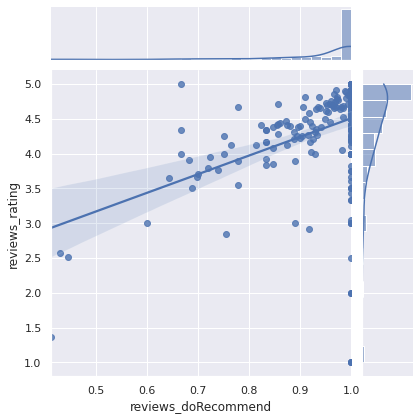

In [103]:
sns.jointplot(x='reviews_doRecommend', y='reviews_rating', data=df_product_user_profile, kind='reg')
plt.show()

We can see that around rating above 4.0 user has more than 80% chance of being recommended

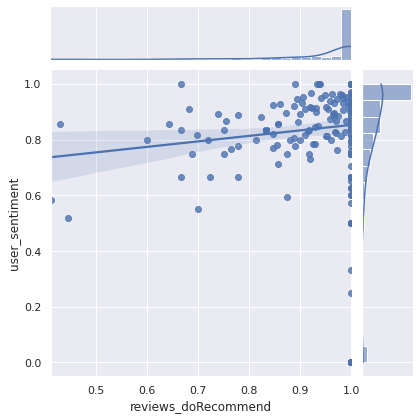

In [104]:
sns.jointplot(x='reviews_doRecommend', y='user_sentiment', data=df_product_user_profile, kind='reg')
plt.show()

We can see that if a product has overall sentiment score of 0.8 and above then its chances of falling in the area with recommendation probablity > 0.8 is good as top-right is very densely populated

In [105]:
# first lets study the data where reviews_doRecommend exist
df_review_recommneded = df_master[~df_master['reviews_doRecommend'].isna()]
df_review_recommneded

,index,reviews_doRecommend,reviews_rating,reviews_text,reviews_username,user_sentiment,name_brand
3,3,False,1,"Disappointed I read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it...",rebecca,Negative,K-Y Love Sensuality Pleasure Gel|K-Y
4,4,False,1,Irritation My husband bought this gel for us. The gel caused irritation and it felt like it was burning my skin. I wouldn't recommend this gel.,walker557,Negative,K-Y Love Sensuality Pleasure Gel|K-Y
5,5,False,1,Not worth it My boyfriend and I bought this to spice things up in the bedroom and we were both highly disappointed in this product. We bought this...,samantha,Negative,K-Y Love Sensuality Pleasure Gel|K-Y
6,6,False,1,Disappointing Bought this earlier today and was excited to check it out. Based on the product description I was expecting something but it was jus...,raeanne,Negative,K-Y Love Sensuality Pleasure Gel|K-Y
7,7,False,1,Not happy at all I bought this product for my husband and I to try and we were not impressed at all. There was no tingling or warming. It left us ...,kimmie,Negative,K-Y Love Sensuality Pleasure Gel|K-Y
...,...,...,...,...,...,...,...
29932,29995,True,5,"Softness!! I got this conditioner with Influenster to try it and im loving it so far, i have oily hair so i use it only in the ends of my hair and...",laurasnchz,Positive,L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz|L'oreal Paris
29933,29996,True,5,"I love it I love it , I received this for review purposes from influenster and it leaves my hair feeling fresh and smelling great",scarlepadilla,Positive,L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz|L'oreal Paris
29934,29997,True,5,Hair is so smooth after use First of all I love the smell of this product. After you wash your hair it is so smooth and easy to brush! I did recei...,liviasuexo,Positive,L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz|L'oreal Paris
29935,29998,True,5,Perfect for my oily hair! I received this through Influenster and will never go back to anything else! I normally don't use conditioner because my...,ktreed95,Positive,L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz|L'oreal Paris


Experiment

In [106]:
df_review_recommneded.columns

Index(['index', 'reviews_doRecommend', 'reviews_rating', 'reviews_text',
       'reviews_username', 'user_sentiment', 'name_brand'],
      dtype='object')

In [107]:
df_rr_gt_4_pos = df_review_recommneded[df_review_recommneded.apply(lambda x: x['reviews_rating'] >= 4 and x['user_sentiment']=='Positive', axis=1)]

In [108]:
df_rr_gt_4_neg = df_review_recommneded[df_review_recommneded.apply(lambda x: x['reviews_rating'] >= 4 and x['user_sentiment']=='Negative', axis=1)]

In [109]:
df_rr_lt_4_pos = df_review_recommneded[df_review_recommneded.apply(lambda x: x['reviews_rating'] < 4 and x['user_sentiment']=='Positive', axis=1)]

In [110]:
df_rr_lt_4_neg = df_review_recommneded[df_review_recommneded.apply(lambda x: x['reviews_rating'] < 4 and x['user_sentiment']=='Negative', axis=1)]

In [111]:
df_rr_gt_4_pos.reviews_doRecommend.value_counts()

True     22712
False       96
Name: reviews_doRecommend, dtype: int64

> #### Probability of reviews_doRecommend = True is very high when 


*   review rating >= 4
*   user_sentiment = 'Positive'

Hence we can direclty impute with True when this condition holds true

In [112]:
df_rr_gt_4_neg.reviews_doRecommend.value_counts()

True     2242
False      18
Name: reviews_doRecommend, dtype: int64

> #### Probability of reviews_doRecommend = True is very high when 


*   review rating >= 4
*   user_sentiment = 'Positive'

Hence we can direclty impute with True when this condition holds true

In [113]:
df_rr_lt_4_pos.reviews_doRecommend.value_counts()

False    898
True     754
Name: reviews_doRecommend, dtype: int64

In [114]:
# probability of being False in the above scenario
round(898/(898+754), 2)

0.54

> #### Probability of reviews_doRecommend = False is higher around 0.54 when


*   review rating less than 4
*   user_sentiment = 'Positive'

Hence we will impute stochastically

In [115]:
df_rr_lt_4_neg.reviews_doRecommend.value_counts()

False    538
True     138
Name: reviews_doRecommend, dtype: int64

In [116]:
# probability of being false in above scenario
round(538/(538+138), 2)

0.8

> #### Probability of reviews_doRecommend = False is far higher around 0.80 when


*   review rating less than 4
*   user_sentiment = 'Negative'

Hence we will impute stochastically here too!

#### Let us write a function which will help us to impute value for reviews_doRecommended


1.   first will deterministically impute in condition where review rating >= 4
2.   in case rating < 4 and user sentiment is postive then will impute value as False stochasitcally with proabibility 0.54
3. in case rating < 4 and user sentiment is postive then will impute value as False stochasitcally with proabibility 0.8

Below is the code for function!



In [117]:
import random
def get_imputed_value(rr, us):
    if rr >=4:
        rcmnd = True
    else:
        random_number = random.random()
        if us == 'Positive':
            if random_number > (1 - 0.54):
                rcmnd = False
            else:
                rcmnd = True
        else:
            if random_number > (1-0.8):
                rcmnd = False
            else: 
                rcmnd = True
    return rcmnd

In [118]:
# testing the function for determistic cases
assert get_imputed_value(4, 'Positive')==True # rr > 4 and user sentiment = Positive
assert get_imputed_value(4, 'Negative')==True # rr > 4 and user sentiment = Negative

In [119]:
test_lt_4_neg = [get_imputed_value(3, 'Negative') for _ in range(100)]

In [120]:
1 - sum(test_lt_4_neg)/100 # calculating total False values percentage

0.8

> **The percentage should be closer to 80 (0.80)**

In [121]:
test_lt_4_pos = [get_imputed_value(3, 'Positive') for _ in range(100)]

In [122]:
1 - sum(test_lt_4_pos)/100 # calculating total False values percentage

0.71

> **The above percentage should be closer to 54 (0.54)**

In [123]:
# index column appeared
df_master.drop('index', inplace=True, axis=1)

In [124]:
df_master.columns

Index(['reviews_doRecommend', 'reviews_rating', 'reviews_text',
       'reviews_username', 'user_sentiment', 'name_brand'],
      dtype='object')

In [125]:
import math
def impute_values(rr, us, rdc):
  if math.isnan(rdc):
    return get_imputed_value(rr, us)
  else:
    return rdc


In [126]:
impute_values(4, 'Positive', np.nan)

True

In [127]:
# now let's impute reviews_doRecommend which are NaN
df_master['reviews_doRecommend'] = df_master.apply(lambda x: impute_values(x['reviews_rating'], x['user_sentiment'], x['reviews_doRecommend']), axis =1 )

In [128]:
# now let us check non-null values overall using info function
df_master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29937 entries, 0 to 29936
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   reviews_doRecommend  29937 non-null  bool  
 1   reviews_rating       29937 non-null  int64 
 2   reviews_text         29748 non-null  object
 3   reviews_username     29937 non-null  object
 4   user_sentiment       29937 non-null  object
 5   name_brand           29937 non-null  object
dtypes: bool(1), int64(1), object(4)
memory usage: 1.2+ MB


> #### Now we have imputed values for all the possible dimensions successfully now let us move towards Text Preprocessing

In [129]:
# now let us copy the df_master to another dataframe for safety purposes during text preprocessing
df_master_1 = df_master.copy()

### 3. Text preprocessing

In [130]:
# removal of stop words, punctuations etc from the text corpus goes here
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [131]:
## initialise the inbuilt Stemmer and the Lemmatizer
stemmer = PorterStemmer()
wordnet_lemmatizer = WordNetLemmatizer()

In [132]:
df_review_text = df_master_1[['reviews_text']]

In [133]:
d = df_master_1['reviews_text'].iloc[0]
d

"Just Awesome i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy."

#### Generally once we go through the csv file column review_text we could find certain words that would add no menainng to our analysis
#### such as prices of product starting with $ sign, mention of age, or metrics such as 40mg
#### so we will remove these words using regex

In [134]:
# a demo example of regex exercise
txt = "$14.99 for the box set 0.55 with digital is not a bad deal. Not the best movies, not the worst movies 40mg 3yearold 2humor. mustn't couldn't"

pattern_for_decimals = r'[a-zA-Z.]*\d[a-zA-Z.]*'

re.sub(pattern_for_decimals, '', txt)

"$ for the box set  with digital is not a bad deal. Not the best movies, not the worst movies    mustn't couldn't"

**Note:** special characters would be taken care by stemming/lematization so we need not bother about that!

#### Since we are trying to perform `Sentiment Analysis` here we cannot remove negation words as a part of stop words removal and would need to handle the case exclusively.

In [135]:
# also we would need to replace occurene of words like couldnt with couldn't and tream them similarily
re.sub('n\'t', 'nt', 'didn\'t wouldn\'t')

'didnt wouldnt'

In [136]:
# let us build a list of negation words assuming that we have replaced single quotes with no character
# turning couldn't into couldnt etc
negation_words = ['no',
 'not',
 'rather',
 'couldnt',
 'wasnt',
 'didnt',
 'wouldnt',
 'shouldnt',
 'werent',
 'dont',
 'doesnt',
 'havent',
 'hasnt',
 'wont',
 'hadnt',
 'never',
 'none',
 'nobody',
 'nothing',
 'neither',
 'nor',
 'nowhere',
 'isnt',
 'cant',
 'cannot',
 'mustnt',
 'mightnt',
 'shant',
 'without',
 'neednt,']

In [137]:
print(negation_words)

['no', 'not', 'rather', 'couldnt', 'wasnt', 'didnt', 'wouldnt', 'shouldnt', 'werent', 'dont', 'doesnt', 'havent', 'hasnt', 'wont', 'hadnt', 'never', 'none', 'nobody', 'nothing', 'neither', 'nor', 'nowhere', 'isnt', 'cant', 'cannot', 'mustnt', 'mightnt', 'shant', 'without', 'neednt,']


In [138]:
# also we need to treat words that are some weird slang expressions having excessive repetion of characters
ptrn = r'(?:(?:0(?=1)|1(?=2)|2(?=3)|3(?=4)|4(?=5)|5(?=6)|6(?=7)|7(?=8)|8(?=9)){2,}\d|(?:a(?=b)|b(?=c)|c(?=d)|d(?=e)|e(?=f)|f(?=g)|g(?=h)|h(?=i)|i(?=j)|j(?=k)|k(?=l)|l(?=m)|m(?=n)|n(?=o)|o(?=p)|p(?=q)|q(?=r)|r(?=s)|s(?=t)|t(?=u)|u(?=v)|v(?=w)|w(?=x)|x(?=y)|y(?=z)){2,}[[:alpha:]])|([a-zA-Z0-9])\1\1+'
re.sub(ptrn, '', 'accutan aalot aaa awesomeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee aaaaahhhhhh aaaaaaaaaaaaaaaaa aaa')

'accutan aalot  awesom   '

In [139]:
import re
import string

# writing a function which will decide if word should be removed or not
def should_be_removed(input_word):
  if input_word in negation_words:
    return False
  else:
    if input_word in stopwords.words("english"):
      return True
    else:
      return False


# lemmatization coverts word into its meaningful base form(lemma), so we will 
# perform lemmatization by default
def preprocess(document, stem=False):
    'changes document to lower case, removes stopwords and lemmatizes/stems the remainder of the sentence'

    # first check if we accidentally encounter something that is float
    document = str(document)
    
    ptrn_repeating_chars = ptrn = r'(?:(?:0(?=1)|1(?=2)|2(?=3)|3(?=4)|4(?=5)|5(?=6)|6(?=7)|7(?=8)|8(?=9)){2,}\d|(?:a(?=b)|b(?=c)|c(?=d)|d(?=e)|e(?=f)|f(?=g)|g(?=h)|h(?=i)|i(?=j)|j(?=k)|k(?=l)|l(?=m)|m(?=n)|n(?=o)|o(?=p)|p(?=q)|q(?=r)|r(?=s)|s(?=t)|t(?=u)|u(?=v)|v(?=w)|w(?=x)|x(?=y)|y(?=z)){2,}[[:alpha:]])|([a-zA-Z0-9])\1\1+'

    # change sentence to lower case
    document = document.lower()

    # convert ambigous negative words into simpler forms couldn't to couldnt
    document = re.sub('n\’t', 'nt', document) # also covering for case of '’' upward comma
    document = re.sub('n\'t', 'nt', document)

    # tokenize into words
    words = word_tokenize(document)

    # remove stop words
    words = [word for word in words if not should_be_removed(word) ]

    if stem:
        words = [stemmer.stem(word) for word in words]
    else:
        words = [wordnet_lemmatizer.lemmatize(word, pos='v') for word in words]

    # join words to make sentence
    document = " ".join(words)

    # remove punctuations
    document = document.translate(str.maketrans('', '', string.punctuation))

    # remove decimals, prices, mention of ages etc
    document = re.sub('[a-zA-Z.]*\d[a-zA-Z.]*', '', document)

    # remove digits all together
    document = re.sub('\d', '', document)

    # remove extra whitespaces
    document = re.sub(' +', ' ', document)

    # removing repeating chars more than 3 times
    document = re.sub(ptrn_repeating_chars, '', document)

    # trim leading and trailing spaces
    document = document.strip()

    # after removal of puncutaion we could again get words like s t etc
    # tokenize into words
    words = word_tokenize(document)

    # remove stop words
    words = [word for word in words if not should_be_removed(word) ]

    # join words to make sentence
    document = " ".join(words)


    return document

In [140]:
stopwords.words("english")

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [141]:
preprocess(d)

'awesome love album good hip hop side current pop sound hype listen everyday gym give rat way metaphors crazy'

In [142]:
# txt has a not word in it lets test it on txt
preprocess(txt)

'box set digital not bad deal not best movies not worst movies mustnt couldnt'

In [143]:
bool(re.search('\d', 'adbc 123 dd'))

True

In [144]:
df_review_text[df_review_text['reviews_text'].apply(lambda x: bool(re.search('\d', str(x))) )]

,reviews_text
0,Just Awesome i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gy...
3,"Disappointed I read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it..."
12,"waste of money Bought this to enhance our time a bit, did abslutely nothing very disappointed especially because its almost 20!"
25,"That little extra something.. I really enjoyed using this product with my husband. After 20+ years of marriage, things can tend to get a little ti..."
26,Great Product! Awesome Product for couples. It is a warm feeling lubricant and not sticky like a lot of other lubricants.It is very easy to clean ...
...,...
29916,My Hair is so SOFT After applying the mask and shampooing 3 times I applied the conditioner mainly focusing on the mids-ends of my hair and just l...
29923,"Must have I received this for free through influenster, paired with the shampoo preshampoo mask! I was definitely skeptical, but after using it fo..."
29924,My hair was so soft after I got this product from Influenster for free to try. I will be switching to this product. After I use conditioner my hai...
29926,Great results This conditioner is great! Leaves hair feeling smooth and super clean!! If you follow all steps 1. Clay mask 2. Shampoo and finish u...


In [145]:
# we will apply lemmatization as it will take care of special charcters too
df_review_text['reviews_text'] = df_review_text['reviews_text'].apply(lambda x: preprocess(str(x)))

In [146]:
# let us check if we are still left with some digits in our text corpus
df_review_text[df_review_text['reviews_text'].apply(lambda x: bool(re.search('\d', str(x))) )]

,reviews_text


#### Let us do a bit of word count analysis on reivew_text
1. first let us find the word count for every document obtained after preprocessing step
2. lets perform a bit of outlier analysis on word count too
3. and also check the reivew text with weird looking values for word count

In [147]:
df_review_text['word_count'] = df_review_text['reviews_text'].apply(lambda x: len(x.split()))

In [148]:
df_review_text.describe()

,word_count
count,29937.000000
mean,19.663827
std,17.350063
min,1.000000
25%,10.000000
50%,15.000000
75%,23.000000
max,538.000000


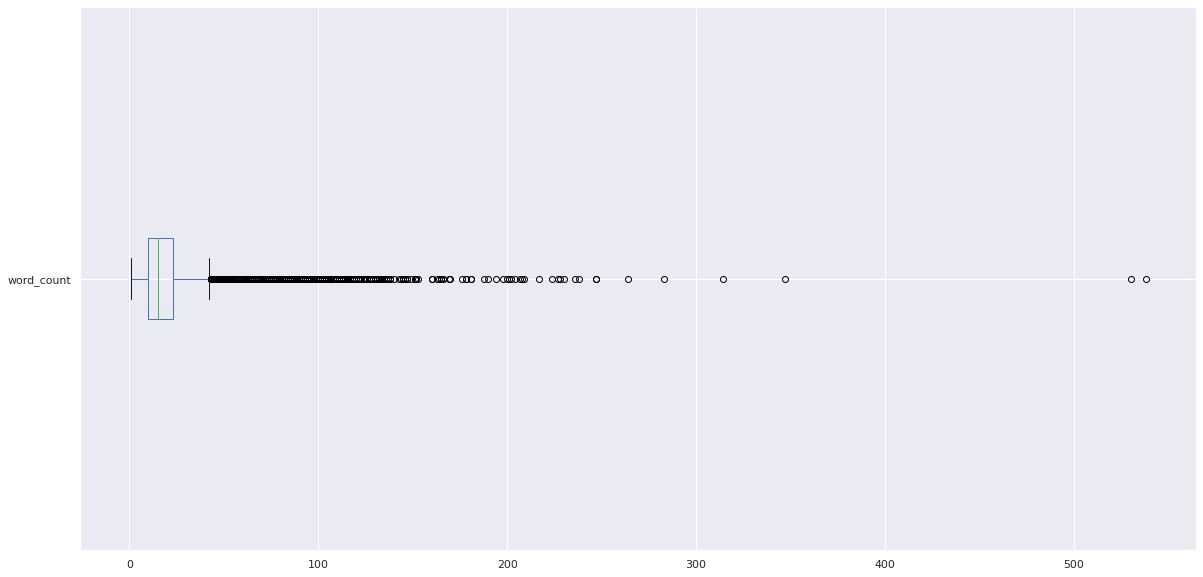

In [149]:
plt.figure(figsize=(20,10))
df_review_text['word_count'].plot.box(vert=False)
plt.show()

> #### Most of the review text have word counts less than 21 (75%). Word counts greater than that are mostly obeserved as outliers.
> #### Let us analyse some of these outliers too to check how they can be dealt

In [150]:
df_review_text['word_count'].value_counts()

11     1969
12     1901
10     1765
13     1664
9      1650
       ... 
283       1
347       1
530       1
194       1
207       1
Name: word_count, Length: 182, dtype: int64

In [151]:
# let us check what all counts exist
sorted(pd.unique(df_review_text['word_count']) )

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 140,
 143,
 144,
 145,
 146,
 147,
 149,
 151,
 152,
 153,
 160,
 163,
 164,
 165,
 166,
 169,
 170,
 176,
 178,
 181,
 188,
 190,
 194,
 198,
 200,
 201,
 202,
 204,
 207,
 208,
 209,
 217,
 224,
 227,
 228,
 230,
 236,
 238,
 247,
 264,
 283,
 314,
 347,
 530,
 538]

In [152]:
df_review_text.query('word_count < 2') 

,reviews_text,word_count
1239,nan,1
1441,nan,1
1442,nan,1
1443,nan,1
1444,nan,1
...,...,...
28727,nan,1
28728,nan,1
28729,nan,1
28730,nan,1


In [153]:
df_review_text.query('word_count == 0') 

,reviews_text,word_count


In [154]:
len(df_review_text.query('word_count > 80'))

369

> #### So what we can do is remove where word_count got zero and remove outliers where word_count > 80 as this would be around only 1-2% of data.
> #### Removing outliers in our case would help us reduce any bias that these records would cause.
> #### Steps to follow:


1.   Pre-process document (every review text in this case of our dataset)
2.   Once preprocessed adding a column that maintains a count of the words
3.   Then removing the rows where word count is zero and greater than 80
4.   We can drop any redundant column afterwards



In [155]:
# df_master_1 is our dataset to operate upon for text preprocessing
df_master_1.columns

Index(['reviews_doRecommend', 'reviews_rating', 'reviews_text',
       'reviews_username', 'user_sentiment', 'name_brand'],
      dtype='object')

In [156]:
# we created df_review_text out df_master_1
sum(df_master_1.index == df_review_text.index) # output should be equal to number of rows

29937

In [157]:
# let us copy df_master_1 to df_master_2 and
# then drop review_text from df_master_1, concat df_reivew_text to it
df_master_2 = df_master_1.copy()

In [158]:
# let us drop review_text from df_master_1, concat df_reivew_text to it
df_master_2.drop('reviews_text', axis=1, inplace = True)
df_master_2 = pd.concat([df_master_2, df_review_text], axis=1 )

In [159]:
df_master_2.head()

,reviews_doRecommend,reviews_rating,reviews_username,user_sentiment,name_brand,reviews_text,word_count
0,True,5,joshua,Positive,Pink Friday: Roman Reloaded Re-Up (w/dvd)|Universal Music,awesome love album good hip hop side current pop sound hype listen everyday gym give rat way metaphors crazy,19
1,True,5,dorothy w,Positive,Lundberg Organic Cinnamon Toast Rice Cakes|Lundberg,good good flavor review collect part promotion,7
2,True,5,dorothy w,Positive,Lundberg Organic Cinnamon Toast Rice Cakes|Lundberg,good good flavor,3
3,False,1,rebecca,Negative,K-Y Love Sensuality Pleasure Gel|K-Y,disappoint read review look buy one couple lubricants ultimately disappoint didnt even live review read starters neither boyfriend nor could notic...,57
4,False,1,walker557,Negative,K-Y Love Sensuality Pleasure Gel|K-Y,irritation husband buy gel us gel cause irritation felt like burn skin wouldnt recommend gel,15


In [160]:
# now let us further clean the date where word count is not zero and is less than 80
sum(df_master_2['word_count'].apply(lambda x: True if x!=0 and x<=80 else False))

29568

In [161]:
sum(df_master_2['word_count'].apply(lambda x: True if x==0 or x>80 else False))


369

In [162]:
df_master_2 = df_master_2[df_master_2['word_count'].apply(lambda x: True if x!=0 and x<=80 else False)]

#### Now let us do final pre-processing that is converting our target variable `user_sentiment` to numeric values i.e 1 for Postive and 0 for negative

In [163]:
df_master_2['user_sentiment'] = df_master_2['user_sentiment'].apply(lambda x: {'Positive': 1, 'Negative': 0}.get(x))

In [164]:
df_master_2.head()

,reviews_doRecommend,reviews_rating,reviews_username,user_sentiment,name_brand,reviews_text,word_count
0,True,5,joshua,1,Pink Friday: Roman Reloaded Re-Up (w/dvd)|Universal Music,awesome love album good hip hop side current pop sound hype listen everyday gym give rat way metaphors crazy,19
1,True,5,dorothy w,1,Lundberg Organic Cinnamon Toast Rice Cakes|Lundberg,good good flavor review collect part promotion,7
2,True,5,dorothy w,1,Lundberg Organic Cinnamon Toast Rice Cakes|Lundberg,good good flavor,3
3,False,1,rebecca,0,K-Y Love Sensuality Pleasure Gel|K-Y,disappoint read review look buy one couple lubricants ultimately disappoint didnt even live review read starters neither boyfriend nor could notic...,57
4,False,1,walker557,0,K-Y Love Sensuality Pleasure Gel|K-Y,irritation husband buy gel us gel cause irritation felt like burn skin wouldnt recommend gel,15


In [165]:
# new shape of our master data after pre-processing
df_master_2.shape

(29568, 7)

In [166]:
# also let us check if after preprocessing we have got any nan values
df_master_2.isna().sum()

reviews_doRecommend    0
reviews_rating         0
reviews_username       0
user_sentiment         0
name_brand             0
reviews_text           0
word_count             0
dtype: int64

In [167]:
# luckily we do not have any na values in our dataset but to be on safer side
# let's drop na
df_master_2.dropna(inplace=True)

### 4. Feature extraction

#### In order to extract features let us start with bag of words to get an intuitive understanding



*   We are using bow on entire dataset just to get a glimpse of how things will look when features get extracted
*   actual bag of words vectorization will happen separately at train and test data after the train-test split
*   SMOTE can be applied only on numeric data so we would need to use vectorizer function before performing oversampling



In [168]:
# importing the required vectorizers
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [169]:
# bag of words model let us check what features we are able to get overall
count_vetcorizer = CountVectorizer()
bow = count_vetcorizer.fit_transform(df_master_2['reviews_text'])

In [170]:
# # returns the row number and column number of the cells which have 1 as value in bow model
# we have 29622 rows and columns number what ever number features would have been extracted
print(type(bow))
print(bow)

<class 'scipy.sparse.csr.csr_matrix'>
  (0, 902)	1
  (0, 7735)	1
  (0, 353)	1
  (0, 5689)	1
  (0, 6282)	1
  (0, 6364)	1
  (0, 11826)	1
  (0, 3133)	1
  (0, 9857)	1
  (0, 12198)	1
  (0, 6512)	1
  (0, 7612)	1
  (0, 4502)	1
  (0, 5964)	1
  (0, 5558)	1
  (0, 10502)	1
  (0, 14386)	1
  (0, 8155)	1
  (0, 3010)	1
  (1, 5689)	2
  (1, 5052)	1
  (1, 11035)	1
  (1, 2464)	1
  (1, 9427)	1
  (1, 10210)	1
  :	:
  (29567, 5558)	1
  (29567, 11035)	1
  (29567, 2464)	1
  (29567, 9427)	1
  (29567, 10210)	1
  (29567, 10136)	2
  (29567, 4681)	1
  (29567, 11379)	1
  (29567, 10554)	2
  (29567, 943)	1
  (29567, 6196)	1
  (29567, 10601)	1
  (29567, 1594)	1
  (29567, 7935)	1
  (29567, 7504)	1
  (29567, 2667)	1
  (29567, 6145)	1
  (29567, 6139)	1
  (29567, 6089)	1
  (29567, 5979)	3
  (29567, 14391)	1
  (29567, 6720)	1
  (29567, 1466)	1
  (29567, 12587)	1
  (29567, 2622)	1


In [171]:
# print the shape of full sparse matrix
print(bow.toarray().shape)

(29568, 14927)


In [172]:
# printng the shape of master dataset at hand
df_master_2.shape

(29568, 7)

> #### So right now every row from the dataset is mapped with 14218 terms along with their freequenies

In [173]:
# printing the features extracted
print(count_vetcorizer.get_feature_names())

['aalot', 'aanyhwere', 'aaron', 'aarontaylor', 'abandon', 'abback', 'abc', 'abcess', 'abd', 'abdominal', 'abhor', 'abilities', 'ability', 'able', 'aboard', 'abomination', 'abortion', 'aboslutely', 'abosolutely', 'abou', 'abovecount', 'abrasion', 'abrasive', 'abrasiveness', 'abroad', 'abs', 'absence', 'absences', 'abslutely', 'absobency', 'absolutally', 'absolute', 'absolutely', 'absolutey', 'absolutley', 'absolutly', 'absoluty', 'absorb', 'absorbent', 'absoutely', 'abt', 'abundance', 'abundant', 'abuse', 'abysmal', 'ac', 'academic', 'academy', 'acapulco', 'accent', 'accentuate', 'accept', 'acceptable', 'acceptably', 'acceptance', 'accesories', 'access', 'accessable', 'accessible', 'accessories', 'accessory', 'accessout', 'accident', 'accidental', 'accidentally', 'accidently', 'accidents', 'acclimate', 'accommodate', 'accommodations', 'accomodate', 'accompaniment', 'accompany', 'accomplish', 'accomplishi', 'accomplishments', 'accord', 'accordingly', 'account', 'accountability', 'account

In [174]:
# the negation words that have appeared in features
[x for x in negation_words if x in count_vetcorizer.get_feature_names()]

['no',
 'not',
 'rather',
 'couldnt',
 'wasnt',
 'didnt',
 'wouldnt',
 'shouldnt',
 'werent',
 'dont',
 'doesnt',
 'havent',
 'hasnt',
 'wont',
 'hadnt',
 'never',
 'none',
 'nobody',
 'nothing',
 'neither',
 'nor',
 'nowhere',
 'isnt',
 'cant',
 'without']

> #### We have around 14K features in our bag of word model. This bag of word model would serve as training data for sentiment analysis

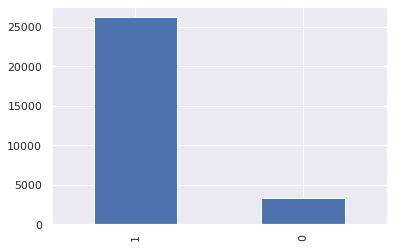

In [175]:
df_master_2.user_sentiment.value_counts().plot.bar()
plt.show()

> #### We have a huge class imbalance here if we go ahead with logistic regression here then most probably we would end up having a huge bias towards 1 (Positive user sentiment)

#### Let us resammple our data using SMOTE to treat the class imbalance

In [177]:
from imblearn.over_sampling import SMOTE

ImportError: ignored

In [ ]:
sm = SMOTE(random_state=2)

**But before we need to perfrom train test split and then perform SMOTE otherwise if we do the split afterwards then some of the data from training may appear in test data as well**

In [ ]:
X = df_master_2[['reviews_text']]
y = df_master_2[['user_sentiment']]

In [ ]:
X.head()

In [ ]:
from sklearn.model_selection import train_test_split

### Train-Test Split

Since BOW should include words from all of the training dataset lets create a BOW first and then perform the test train split

In [ ]:
# tfidf_vectorizer = TfidfVectorizer()

In [ ]:
X_bow = count_vetcorizer.fit_transform(X.values.ravel())

In [ ]:
X_bow.shape

In [ ]:
# now let us perform the train test split
X_train_bow, X_test_bow, y_train, y_test = train_test_split(X_bow, y, test_size=0.3, random_state=0)

In [ ]:
# also let us reset index for the above
# X_train_bow.reset_index(inplace=True, drop=True) # not required
# X_test_bow.reset_index(inplace=True, drop=True) # not required
y_train.reset_index(inplace=True, drop=True)
y_test.reset_index(inplace=True, drop=True)

In [ ]:
X_train_bow.shape

In [ ]:
X_test_bow.shape

In [ ]:
y_train.shape

In [ ]:
y_test.shape

#### Now we have out test and train data in vectorized format (BOW)

Now let us resample our data

In [ ]:
# resampling training data
X_train_res, y_train_res = sm.fit_sample(X_train_bow, y_train)

In [ ]:
X_train_res.shape

In [ ]:
y_train_res.shape

Now let us check the class imbalance

In [ ]:
sum(y_train_res)/y_train_res.shape[0]

We can see that 1 accounts for 50% of the data and other would be 0. So class imbalance is treated

We can see that SMOTE has increase the samples of Minority class to make it equal in size with Majority class.

> #### We have successfully resmapled our dataset
(need to check why the shape of y changed)

#### Also we can see that number of features produced after vectorization is huge. So we need to reduce the dimnesionality in order to proceed with logistic regression.

#### This can be handled using PCA ( Principal Component Analysis) which is one of the dimensionality reduction technique. We will use scikit lean TruncatedSVD as PCA is not applicable to sparse matrix

In [ ]:
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import mean_squared_error, accuracy_score, recall_score, classification_report, confusion_matrix, f1_score, precision_score

In [ ]:
truncatedSVD = TruncatedSVD(random_state=42, n_components=5000)

In [ ]:
truncatedSVD.fit(X_train_res)

In [ ]:
len(truncatedSVD.components_)

In [ ]:
var_cumu = np.cumsum(truncatedSVD.explained_variance_ratio_)

In [ ]:
plt.figure(figsize=(30,15))
plt.plot(range(1,len(var_cumu)+1), var_cumu)
# first point at x=2000, y=0.95
plt.vlines(x=2000, ymax=1.1, ymin=0.8, colors="r", linestyles="--")
plt.hlines(y=0.9625, xmax=2300, xmin=1500, colors="g", linestyles="--")

# second point at x=3000, y=0.98
plt.vlines(x=3000, ymax=1.00, ymin=0.93, colors="r", linestyles="--")
plt.hlines(y=0.98, xmax=3200, xmin=2800, colors="g", linestyles="--")

# third point at x=4000, y=0.99
plt.vlines(x=4000, ymax=1.04, ymin=0.95, colors="r", linestyles="--")
plt.hlines(y=0.99, xmax=3900, xmin=4100, colors="g", linestyles="--")

# fourth point at x=5000, y=0.998
plt.vlines(x=5000, ymax=1.02, ymin=0.95, colors="r", linestyles="--")
plt.hlines(y=0.9955, xmax=4900, xmin=5100, colors="g", linestyles="--")

plt.xlabel('Number of principal components', fontsize=16)
plt.ylabel('Total Explained Variance', fontsize=16)
plt.show()

#### We can see that variance ration is explained beautifully for n_components < 5000


1.   n_component = 2000, explained variance = 96.25%
2.   n_component = 3000, explained variance = 98.00%
3.   n_component = 4000, explained variance = 99.00%
4.   n_component = 5000, explained variance = 99.50%

We shall choose n_components as `3000` as it is explaining around 98% of the variance. 96.25% is too low and for an increase of 1% from 98 to 99 number of features are increasing by 1000. Therefore it is not worth it chosing over 3000



In [ ]:
# creating the optimally chosen truncated SVD
truncatedSVD_optimal = TruncatedSVD(random_state=42, n_components=3000)

Now let us apply optimaly Truncated SVD on our resampled train dataset

In [ ]:
X_train_tsvd = truncatedSVD_optimal.fit_transform(X_train_res)

In [ ]:
X_train_tsvd.shape

We can see that now that feature dimnesionality is reduced to 3000. Now let us train logistic regression model on it.

Also we need to transform our test data as well using our optimal svd let say `X_test_svd`

In [ ]:
X_test_svd = truncatedSVD_optimal.fit_transform(X_test_bow)

In [ ]:
X_test_svd.shape

#### Normalization of data

In [ ]:
X_test_svd

In [ ]:
from sklearn import preprocessing

In [ ]:
scaler = preprocessing.MinMaxScaler()

In [ ]:
X_train_scaled = scaler.fit_transform(X_train_tsvd)

In [ ]:
X_train_scaled

In [ ]:
X_train_scaled.shape

In [ ]:
X_test_scaled = scaler.fit_transform(X_test_svd)

## Model Building, Evaluation and Selection

### Model Building and Evaluation using Logistic Regression


*   Bag of words with Logistic Regression based Classifier



In [ ]:
from sklearn.linear_model import LogisticRegression
lgst = LogisticRegression(max_iter=1000)

In [ ]:
from sklearn.metrics import mean_squared_error, accuracy_score, recall_score, classification_report, confusion_matrix, f1_score, make_scorer

In [ ]:
lgst_classifier = lgst.fit(X_train_scaled, y_train_res)

In [ ]:
y_predicted = lgst_classifier.predict(X_test_scaled)

In [ ]:
y_train_predct = lgst_classifier.predict(X_train_scaled)

**On training data**

In [ ]:
recall_score(y_train_res, y_train_predct)

0.9479450561430285

In [ ]:
accuracy_score(y_train_res, y_train_predct)

0.9547312765725499

In [ ]:
precision_score(y_train_res, y_train_predct)

0.9609880090622755

In [ ]:
f1_score(y_train_res, y_train_predct)

0.9544219740416542

**On test data**

In [ ]:
accuracy_score(y_test, y_predicted)

0.8563859767782662

In [ ]:
recall_score(y_test, y_predicted)

0.9545800558233951

In [ ]:
precision_score(y_test, y_predicted)

0.8914691943127963

In [ ]:
f1_score(y_test, y_predicted)

0.9219458399705919

> We can see that accuracy on training dataset is much higher around 95% where as on test data is significantly lower around 64%. Clearly this is case of overfitting.
> We would need to perfrom hyper-parameter tuning for it to regularize over-fitting.

#### Hyper-parameter tuning for logistic regression using Grid Search CV  
We will use the hyper-parameter C which is the Inverse of regularization strength. Default value is 1.0, lower the C value stronger the regularization. We will take a sample of c values to expierment with and chose the one which gave us the best train-to-test accuracy deal.  
Also we will use l2 regularization in this case for simplicity as we have already done PCA using truncatedSVD and we are not interested in feature elimination any further

Trying a couple of ranges to use further

In [ ]:
np.logspace(-12, -1, 10)

array([1.00000000e-12, 1.66810054e-11, 2.78255940e-10, 4.64158883e-09,
       7.74263683e-08, 1.29154967e-06, 2.15443469e-05, 3.59381366e-04,
       5.99484250e-03, 1.00000000e-01])

In [ ]:
np.linspace(0.1,1.5,15)

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5])

**Accuracy Grid Search CV**

In [ ]:
# GridSearchCV to find optimal C value
from sklearn.model_selection import GridSearchCV

# specify number of folds
n_folds = 5

# specify the range of c values no point of reaching at 1.0 as it is default
c_param_range = np.logspace(-12, -1, 10)

# parameters to build the model on
parameters = {
    'penalty' : ['l2'],
    'C' : c_param_range,
    'max_iter': [1000]
    }

# instantiate the model
lgf = LogisticRegression(max_iter=1000)





In [ ]:
# fit tree on training data
lgf = GridSearchCV(lgf, parameters, 
                    cv=n_folds,
                  return_train_score=True,
                   scoring="accuracy")


In [ ]:
lgf.fit(X_train_scaled, y_train_res)

GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=1000, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([1.00000000e-12, 1.66810054e-11, 2.78255940e-10, 4.64158883e-09,
       7.74263683e-08, 1.29154967e-06, 2.15443469e-05, 3.59381366e-04,
       5.99484250e-03, 1.00000000e-01]),
                         'max_iter': [1000], 'penalty': ['l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True

In [ ]:
# scores of GridSearch CV
scores = lgf.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_max_iter,param_penalty,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.632783,0.008251,0.033950,0.002843,1e-12,1000,l2,"{'C': 1e-12, 'max_iter': 1000, 'penalty': 'l2'}",0.499932,0.664123,0.5,0.5,0.5,0.532811,0.065656,8,0.500017,0.643921,0.5,0.5,0.5,0.528788,0.057567
1,0.626221,0.007413,0.034159,0.002687,1.6681e-11,1000,l2,"{'C': 1.6681005372000556e-11, 'max_iter': 1000, 'penalty': 'l2'}",0.499932,0.664123,0.5,0.5,0.5,0.532811,0.065656,8,0.500017,0.643921,0.5,0.5,0.5,0.528788,0.057567
2,0.918289,0.234324,0.033897,0.003992,2.78256e-10,1000,l2,"{'C': 2.782559402207126e-10, 'max_iter': 1000, 'penalty': 'l2'}",0.499932,0.499932,0.5,0.5,0.5,0.499973,0.000033,10,0.500017,0.500017,0.5,0.5,0.5,0.500007,0.000008
3,0.773409,0.059566,0.032529,0.001120,4.64159e-09,1000,l2,"{'C': 4.641588833612792e-09, 'max_iter': 1000, 'penalty': 'l2'}",0.499932,0.697915,0.5,0.5,0.5,0.539569,0.079173,7,0.500017,0.677341,0.5,0.5,0.5,0.535472,0.070935
4,0.733003,0.008863,0.032110,0.001011,7.74264e-08,1000,l2,"{'C': 7.742636826811277e-08, 'max_iter': 1000, 'penalty': 'l2'}",0.499932,0.748740,0.5,0.5,0.5,0.549734,0.099503,6,0.500017,0.728546,0.5,0.5,0.5,0.545713,0.091417


#### Examining the Gridsearch CV score for accuracy

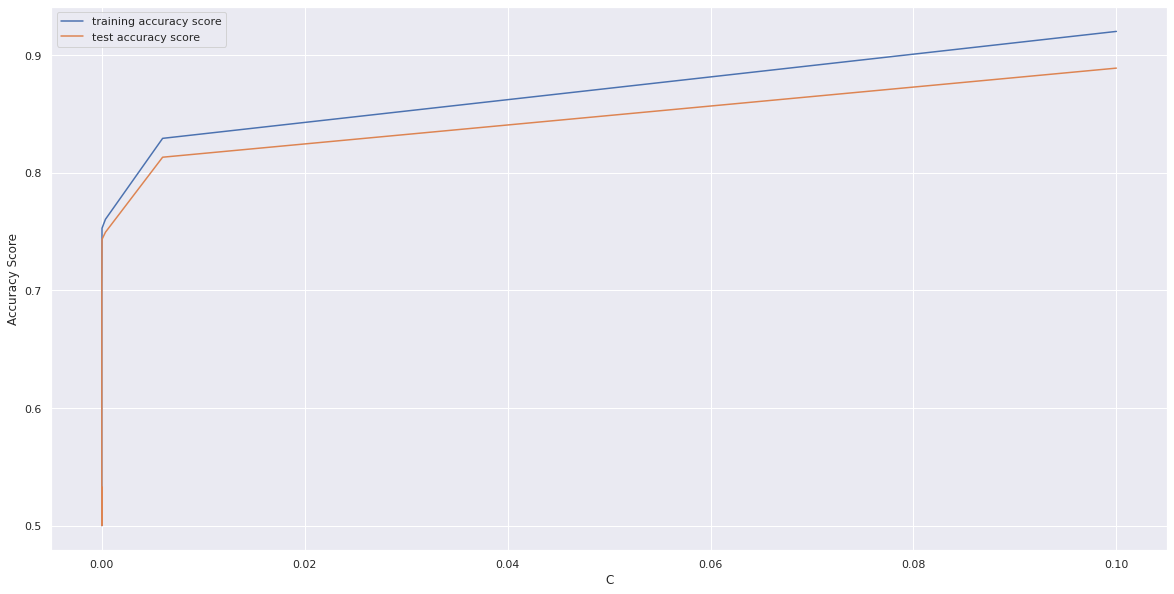

In [ ]:
# plotting recall scores with n_estimators
plt.figure(figsize=(20,10))
plt.plot(scores["param_C"], 
         scores["mean_train_score"], 
         label="training accuracy score")
plt.plot(scores["param_C"], 
         scores["mean_test_score"], 
         label="test accuracy score")
plt.xlabel("C")
plt.ylabel("Accuracy Score")
plt.legend()
plt.show()

In [ ]:
lgf.best_params_

{'C': 0.1, 'max_iter': 1000, 'penalty': 'l2'}

In [ ]:
# chosing optimal logistic regression model
lgst_optimal = LogisticRegression(**lgf.best_params_)

In [ ]:
lgst_opt_clf = lgst_optimal.fit(X_train_scaled, y_train_res)

In [ ]:
y_opt_predicted = lgst_opt_clf.predict(X_test_scaled)

In [ ]:
y_train_predct_opt = lgst_opt_clf.predict(X_train_scaled)

Train Metric

In [ ]:
recall_score(y_train_res, y_train_predct_opt)

0.8963261746429739

In [ ]:
accuracy_score(y_train_res, y_train_predct_opt)

0.9234438024637524

In [ ]:
precision_score(y_train_res, y_train_predct_opt)

0.9477263558296352

Test Metric

In [ ]:
recall_score(y_test, y_opt_predicted)

0.9129662522202486

In [ ]:
precision_score(y_test, y_opt_predicted)

0.8996124515564445

In [ ]:
accuracy_score(y_test, y_opt_predicted)

0.8321497012738136

In [ ]:
f1_score(y_test, y_opt_predicted)

0.9062401611989168

We can see that grid search cv analysis still gave better results as compared to while running it on altogether test data  
Couple of reasons could be


*   there is generally a trade off between precision and recall
*   we got precision of 89% that means if a predictions is made to be a POSITIVE then it is higly likely to be correct as Precisions = TP/(TP+FP)


In [ ]:
# let us experiment with one more just for our satisfaction
# since C=0.1 gave us the best parameter let us reduce value for C
# bringing it to diametrically opposite side of the decimal number line
# such that precision decreases and recall increases
# on test metric

In [ ]:
lgst_expr = LogisticRegression(C=1e+5, max_iter=1000)

In [ ]:
lgst_expr.get_params()

{'C': 100000.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 1000,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [ ]:
lgst_expr_clf = lgst_expr.fit(X_train_scaled, y_train_res)

In [ ]:
y_train_expr_pred = lgst_expr_clf.predict(X_train_scaled)

Training Metrics

In [ ]:
accuracy_score(y_train_res, y_train_expr_pred)

0.9757167774991824

In [ ]:
precision_score(y_train_res, y_train_expr_pred)

0.9737284915594637

In [ ]:
recall_score(y_train_res, y_train_expr_pred)

0.9778153275918456

In [ ]:
f1_score(y_train_res, y_train_expr_pred)

0.9757676303407761

Testing Metrics

In [ ]:
y_test_pred = lgst_expr_clf.predict(X_test_scaled)

In [ ]:
accuracy_score(y_test, y_test_pred)

0.8740840942396573

In [ ]:
precision_score(y_test, y_test_pred)

0.8908145580589255

In [ ]:
recall_score(y_test, y_test_pred)

0.9781781273788379

In [ ]:
f1_score(y_test, y_test_pred)

0.9324544959787144

> #### We are able to get a model whose precision is 92% and recall is around 62%. We could not do better than this. Hence here we will persist the model

**F1 Score Grid search cv**

Examining the grid search CV we did earlier let us start with 0.1 go till 1e+7 and check for F1 score this time

In [ ]:
np.logspace(-1, 7, 10)

array([1.00000000e-01, 7.74263683e-01, 5.99484250e+00, 4.64158883e+01,
       3.59381366e+02, 2.78255940e+03, 2.15443469e+04, 1.66810054e+05,
       1.29154967e+06, 1.00000000e+07])

In [ ]:
from sklearn.model_selection import GridSearchCV

# specify number of folds
n_folds = 5

# specify the range of c values no point of reaching at 1.0 as it is default
c_param_range = np.logspace(-1, 7, 10)

# parameters to build the model on
parameters = {
    'penalty' : ['l2'],
    'C' : c_param_range,
    'max_iter': [1000]
    }

# instantiate the model
lgf_f1 = LogisticRegression(max_iter=1000)

In [ ]:
# fit on training data
lgf_f1 = GridSearchCV(lgf_f1, parameters, 
                    cv=n_folds,
                  return_train_score=True,
                   scoring="f1")

In [ ]:
lgf_f1.fit(X_train_scaled, y_train_res)

GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=1000, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([1.00000000e-01, 7.74263683e-01, 5.99484250e+00, 4.64158883e+01,
       3.59381366e+02, 2.78255940e+03, 2.15443469e+04, 1.66810054e+05,
       1.29154967e+06, 1.00000000e+07]),
                         'max_iter': [1000], 'penalty': ['l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True

In [ ]:
# scores of GridSearch CV
scores = lgf_f1.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_max_iter,param_penalty,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,13.649362,2.220572,0.037543,0.000702,0.1,1000,l2,"{'C': 0.1, 'max_iter': 1000, 'penalty': 'l2'}",0.816643,0.904249,0.903123,0.904070,0.907085,0.887034,0.035220,10,0.931739,0.914782,0.916216,0.913861,0.913775,0.918075,0.006888
1,39.764306,5.328604,0.037172,0.001553,0.774264,1000,l2,"{'C': 0.774263682681127, 'max_iter': 1000, 'penalty': 'l2'}",0.832361,0.931475,0.931148,0.930758,0.937065,0.912562,0.040167,8,0.969753,0.949838,0.950330,0.950440,0.948738,0.953820,0.007989
2,81.633990,12.537601,0.036493,0.001498,5.99484,1000,l2,"{'C': 5.994842503189409, 'max_iter': 1000, 'penalty': 'l2'}",0.829429,0.939101,0.941578,0.938363,0.944766,0.918647,0.044665,1,0.985727,0.966213,0.965673,0.965727,0.965204,0.969709,0.008016
3,143.509706,1.179162,0.036275,0.001151,46.4159,1000,l2,"{'C': 46.41588833612777, 'max_iter': 1000, 'penalty': 'l2'}",0.821291,0.939937,0.942163,0.938683,0.943439,0.917103,0.047935,2,0.990558,0.973989,0.973407,0.974141,0.972607,0.976940,0.006830
4,145.198502,1.422295,0.035907,0.000911,359.381,1000,l2,"{'C': 359.38136638046257, 'max_iter': 1000, 'penalty': 'l2'}",0.816723,0.938781,0.941461,0.938078,0.941627,0.915334,0.049326,3,0.992302,0.977438,0.975972,0.977399,0.976029,0.979828,0.006269


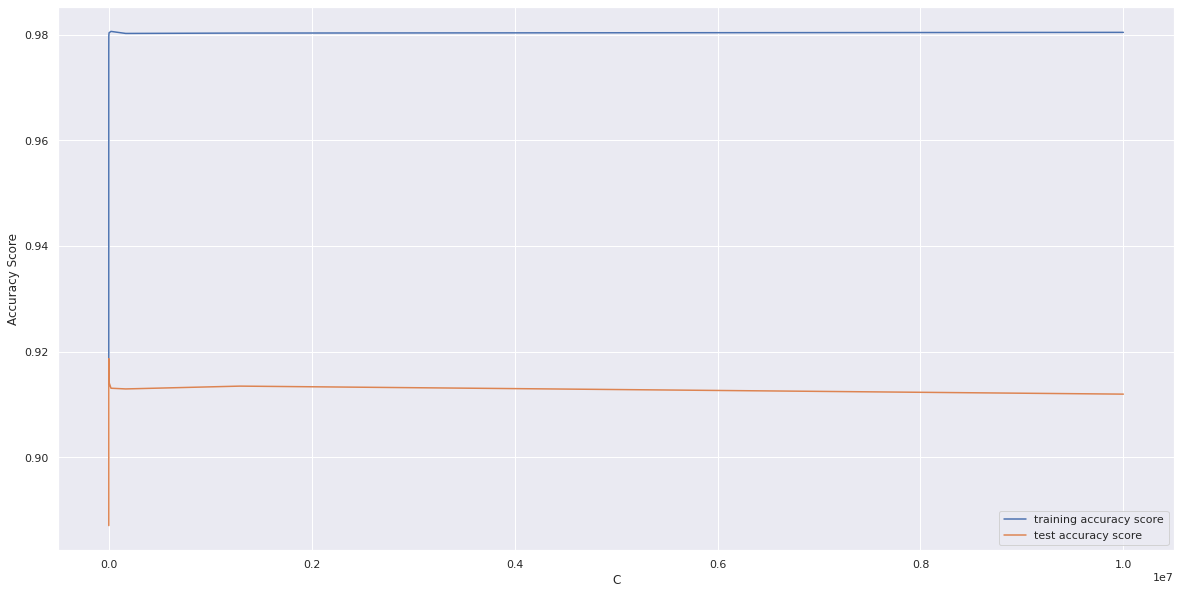

In [ ]:
# plotting recall scores with n_estimators
plt.figure(figsize=(20,10))
plt.plot(scores["param_C"], 
         scores["mean_train_score"], 
         label="training accuracy score")
plt.plot(scores["param_C"], 
         scores["mean_test_score"], 
         label="test accuracy score")
plt.xlabel("C")
plt.ylabel("Accuracy Score")
plt.legend()
plt.show()

We can see that f1 accuracy saturates around 92%. The exercise was not worth it. Hence we will use lgst_expr as our optimal one and persist it

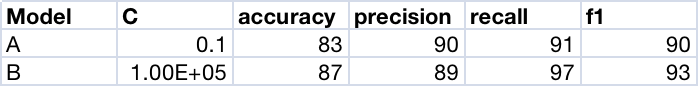

> #### Selecting Model B

In [ ]:
import joblib

In [ ]:
# ignoring below one, as our decision changed on selection of logistic regression model
# joblib.dump(lgst_opt_clf, '/content/gdrive/MyDrive/Colab Notebooks/Sentiment Based Product Recommendation System/logistic_user_sentiment_classifer.sav')

In [ ]:
joblib.dump(lgst_expr_clf, '/content/gdrive/MyDrive/Colab Notebooks/Sentiment Based Product Recommendation System/logistic_user_sentiment_classifer.sav')

['/content/gdrive/MyDrive/Colab Notebooks/Sentiment Based Product Recommendation System/logistic_user_sentiment_classifer.sav']

In [ ]:
# create a pipeline of transformations and dump
from sklearn.pipeline import Pipeline

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression

Prediction steps


1.   Create Bag of Words Model using Count Vectorizer
2.   Then perform TruncatedSVD performing feature elimination
3.   Normalize using MinMaxScaling
4.   Performing Logistic Regression using optimal hyper parameters



In [ ]:
small_testset = [
                 'awesome love album good hip hop side current pop sound hype listen everyday gym give rat way metaphors crazy',
                 'love love review collect part promotion',
                 'nasty smell would get anyone sick wont recommend product anyone'
]

In [ ]:
a = count_vetcorizer.transform(small_testset)
a

<3x14927 sparse matrix of type '<class 'numpy.int64'>'
	with 33 stored elements in Compressed Sparse Row format>

In [ ]:
b = truncatedSVD_optimal.transform(a)
b

array([[ 4.79105923e-01,  3.23996397e-01, -1.82809407e-01, ...,
        -7.82584077e-03, -7.96968943e-03, -1.70744538e-02],
       [ 1.63101957e+00, -6.33350228e-01, -3.89094827e-01, ...,
         7.98256720e-04,  2.05839192e-05,  4.59279656e-04],
       [ 5.50745316e-01,  2.93820123e-01,  5.12329249e-01, ...,
        -1.95141591e-03, -3.26973776e-04,  1.06195956e-02]])

In [ ]:
c = scaler.transform(b)
c

array([[0.07082927, 0.41129695, 0.42207508, ..., 0.4278955 , 0.4176475 ,
        0.44529409],
       [0.24112396, 0.28683081, 0.40037029, ..., 0.45770719, 0.44856184,
        0.49985772],
       [0.08142017, 0.40737368, 0.49521565, ..., 0.44820215, 0.44721714,
        0.53147584]])

In [ ]:
lgst_expr_clf.predict(c)

array([1, 1, 1])

In [ ]:
class LRModel:
  '''
  A model wrapper which would have all the transformations
  '''
  def __init__(self, vectr, svd, scaler, clf):
    self.vectr = vectr
    self.svd = svd
    self.scaler = scaler
    self.clf = clf
  
  def predict(self, data):
    data_1 = self.vectr.transform(data)
    data_2 = self.svd.transform(data_1)
    data_3 = self.scaler.transform(data_2)
    result = self.clf.predict(data_3)
    return result


In [ ]:
lr_model = LRModel(count_vetcorizer, truncatedSVD_optimal, scaler, lgst_expr_clf)

In [ ]:
lr_model.clf

LogisticRegression(C=100000.0, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
lr_model.predict(small_testset)

array([1, 1, 1])

#### Persisting Machine Learning Pipeline that would be used to predict

In [ ]:
# joblib.dump(lr_model, '/content/gdrive/MyDrive/Colab Notebooks/Sentiment Based Product Recommendation System/logistic_user_sentiment_classifer_pipeline.sav')

['/content/gdrive/MyDrive/Colab Notebooks/Sentiment Based Product Recommendation System/logistic_user_sentiment_classifer_pipeline.sav']

In [ ]:
# testing once by loading the model again
ppln = joblib.load('/content/gdrive/MyDrive/Colab Notebooks/Sentiment Based Product Recommendation System/logistic_user_sentiment_classifer_pipeline.sav')

In [ ]:
type(ppln)

__main__.LRModel

In [ ]:
ppln.predict(small_testset)

array([1, 1, 1])

### Model Building and Evaluation using random Forest

##### First let us get Tf-Idf vectorized data after resampling

In [ ]:
# for sake of rememberance
y_train_tfidf = y_train.copy()
y_test_tfidf = y_test.copy()

In [ ]:
# training dataset for sentiemtn analysis modelling
X_train

,reviews_text
0,great product nurse hate germs clorox kill germs thats use review collect part promotion
1,awesome clorox disinfect wipe awesome use clean things kitchen restrooms outside furniture closet etc
2,disinfect like boss say convenient disinfect like boss clorox wipe thats wont disappoint product wont go back anything else try review collect par...
3,new formula horrible disappoint brand products use holy grail use recommend everybody suppose plus scent great new formula honestly terrible wash ...
4,good prodjct terrible smell use hair gel many years recently nexxus change product add fragrance horrible please bring back original gel
...,...
20692,clorox rock clorox best disinfectant ever use love convenient spray bottle versions along easy use wipe portable effective best review collect par...
20693,great product cleaner work great kid age mrs constantly clean wipe find product clean best
20694,fast easy love convenience clorox wipe much easier grab wet wipe use messy spray review collect part promotion
20695,use almost everything buy tubs month use clean counter stave microwave especially bathroom nice throw wipe away not germs linger sponge find new t...


In [ ]:
# creating vectorizer object
tfidf_vectorizer = TfidfVectorizer()

In [ ]:
# vectorizing data into TF-IDF format
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train.values.ravel())
X_test_tfidf = tfidf_vectorizer.fit_transform(X_test.values.ravel())

In [ ]:
X_train_tfidf.shape

(20697, 12461)

In [ ]:
X_test_tfidf.shape

(8871, 8311)

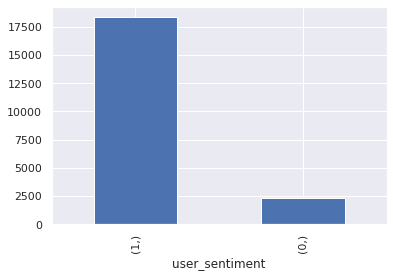

In [ ]:
# class imbalance on y
y_train_tfidf.value_counts().plot.bar()
plt.show()

In [ ]:
# treating class imbalance by SMOTE
X_train_tfidf_res, y_train_tfidf_res = sm.fit_sample(X_train_tfidf, y_train_tfidf)

In [ ]:
X_train_tfidf_res.shape

(36692, 12461)

In [ ]:
y_train_tfidf_res.shape

(36692,)

In [ ]:
X_train_tfidf

<20697x12461 sparse matrix of type '<class 'numpy.float64'>'
	with 330933 stored elements in Compressed Sparse Row format>

In [ ]:
print(X_train_tfidf)

  (0, 8488)	0.12687872857333332
  (0, 7841)	0.12506565075394502
  (0, 2040)	0.1267199829912801
  (0, 9189)	0.12497513231893392
  (0, 11666)	0.12077384154539149
  (0, 10960)	0.438989688837077
  (0, 6019)	0.3138817703359211
  (0, 1951)	0.1655639418824207
  (0, 4602)	0.5073738904922708
  (0, 5084)	0.36372887418667044
  (0, 7445)	0.42712052861353894
  (0, 8431)	0.1349932941151456
  (0, 4866)	0.11388629001054719
  (1, 3716)	0.28061315910829954
  (1, 1967)	0.42230772261248545
  (1, 4501)	0.33945582589064804
  (1, 7721)	0.33756084486996435
  (1, 9155)	0.427998506873727
  (1, 6045)	0.19217350918044565
  (1, 11030)	0.24571445851067195
  (1, 1876)	0.12233458804251825
  (1, 12196)	0.1275296970622517
  (1, 3134)	0.17075401495339876
  (1, 744)	0.37796168818019293
  (1, 11666)	0.10208265527372606
  :	:
  (20695, 7310)	0.1192449072793088
  (20695, 4409)	0.12470259996481786
  (20695, 5286)	0.11971855306412749
  (20695, 4136)	0.23190742531168765
  (20695, 7398)	0.08170326988245556
  (20695, 6448)	0.059

Now again we have the classic curse of dimnestionality case here. Features are 12461 so we will use truncated SVD

In [ ]:
truncatedSVD_tfidf = TruncatedSVD(random_state=42, n_components=5000)

In [ ]:
truncatedSVD_tfidf.fit(X_train_tfidf_res)

TruncatedSVD(algorithm='randomized', n_components=5000, n_iter=5,
             random_state=42, tol=0.0)

In [ ]:
var_cumu_tfidf = np.cumsum(truncatedSVD_tfidf.explained_variance_ratio_)

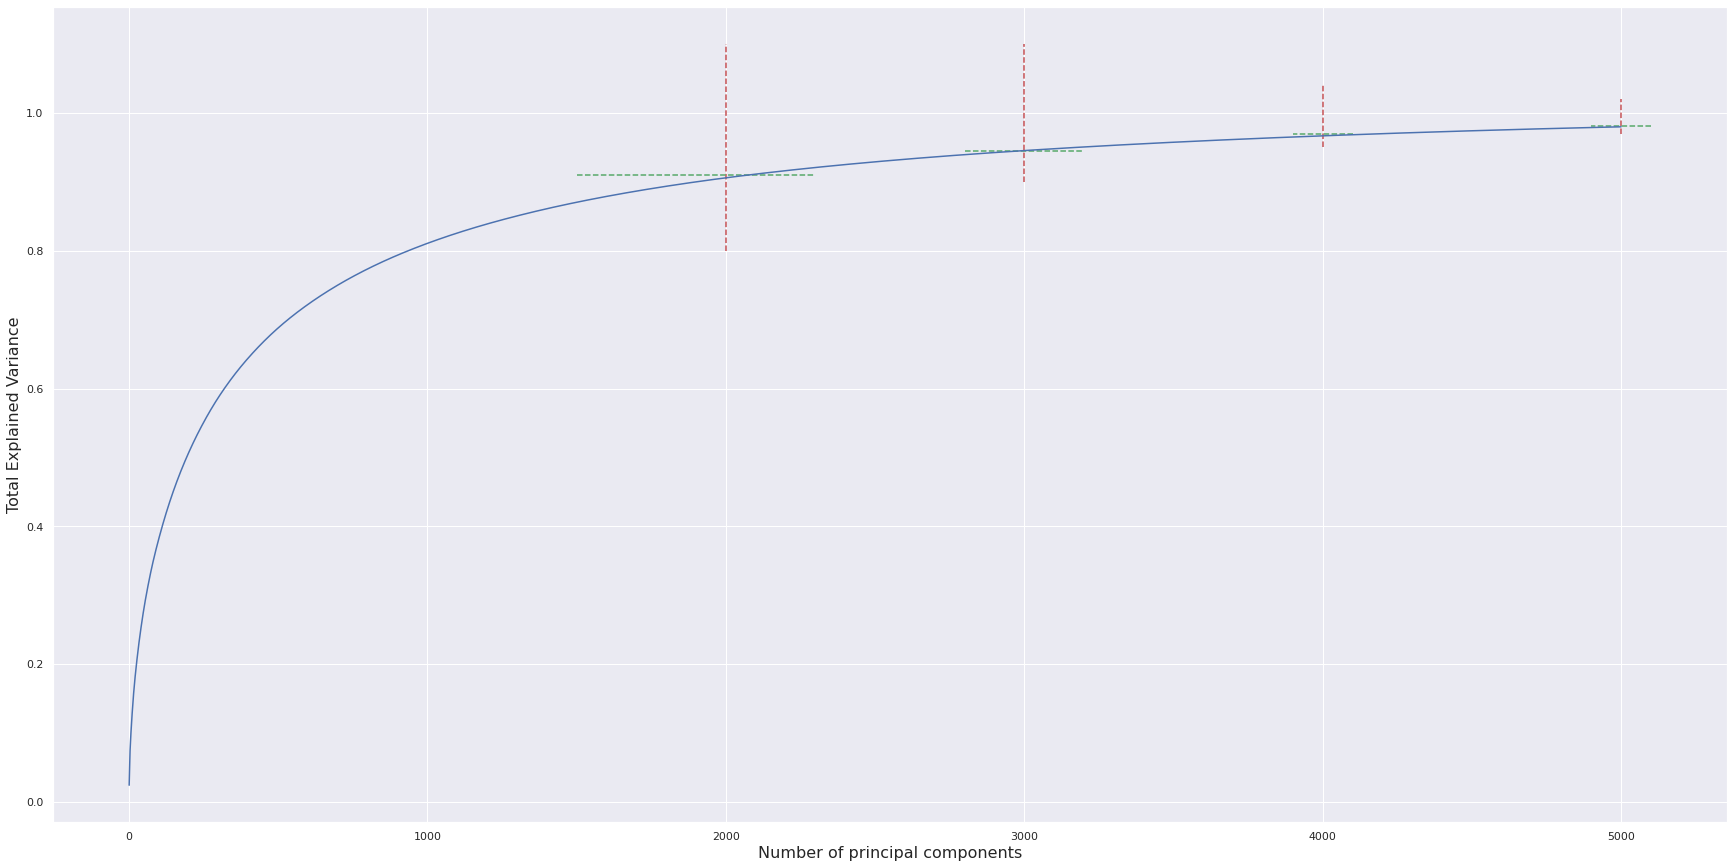

In [ ]:
plt.figure(figsize=(30,15))
plt.plot(range(1,len(var_cumu_tfidf)+1), var_cumu_tfidf)
# first point at x=2000, y=0.95
plt.vlines(x=2000, ymax=1.1, ymin=0.8, colors="r", linestyles="--")
plt.hlines(y=0.9105, xmax=2300, xmin=1500, colors="g", linestyles="--")

# second point at x=3000, y=0.98
plt.vlines(x=3000, ymax=1.1, ymin=0.9, colors="r", linestyles="--")
plt.hlines(y=0.945, xmax=3200, xmin=2800, colors="g", linestyles="--")

# third point at x=4000, y=0.99
plt.vlines(x=4000, ymax=1.04, ymin=0.95, colors="r", linestyles="--")
plt.hlines(y=0.97, xmax=3900, xmin=4100, colors="g", linestyles="--")

# fourth point at x=5000, y=0.998
plt.vlines(x=5000, ymax=1.02, ymin=0.97, colors="r", linestyles="--")
plt.hlines(y=0.981, xmax=4900, xmin=5100, colors="g", linestyles="--")

plt.xlabel('Number of principal components', fontsize=16)
plt.ylabel('Total Explained Variance', fontsize=16)
plt.show()

Here it is wise to chose number of principa components as 5000 as it explains 98% of the variance

In [ ]:
truncatedSVD_tfidf_optimal = TruncatedSVD(random_state=42, n_components=5000)

In [ ]:
X_train_tfidf_tsvd = truncatedSVD_tfidf_optimal.fit_transform(X_train_tfidf_res)
X_test_tfidf_svd = truncatedSVD_tfidf_optimal.fit_transform(X_test_tfidf)

In [ ]:
X_train_tfidf_tsvd

array([[ 3.17268713e-01, -5.21363032e-02, -5.95422088e-04, ...,
        -2.72654681e-04, -7.81279532e-04, -8.55581586e-04],
       [ 1.99671704e-01, -5.39584719e-02, -2.27995446e-02, ...,
        -7.55645777e-04,  1.72394175e-04,  3.16857212e-03],
       [ 2.65268139e-01, -6.09851866e-03,  4.33445496e-02, ...,
         1.04709645e-03,  5.43105880e-04,  1.83861047e-03],
       ...,
       [ 3.61637237e-02,  1.23162547e-01, -8.95849139e-02, ...,
        -6.58073362e-04, -6.15481480e-04,  8.29765144e-05],
       [ 1.24492113e-01,  9.31924047e-02,  9.71384471e-02, ...,
        -3.94864994e-04,  1.65187453e-03, -1.54849323e-03],
       [ 2.55517983e-02,  3.94294783e-02,  9.16259744e-03, ...,
         5.19189598e-05, -5.90753805e-04, -5.68693894e-05]])

In [ ]:
X_train_tfidf_tsvd.shape

In [ ]:
X_test_tfidf_svd.shape

(8871, 5000)

In [ ]:
truncatedSVD_tfidf_optimal.components_

array([[ 1.53363189e-05,  7.26582094e-05,  9.10196594e-05, ...,
         2.27847614e-04,  5.11207999e-05,  5.29148611e-05],
       [ 9.01075079e-05,  1.08009900e-04,  5.50483941e-06, ...,
         1.36488600e-03,  1.69905052e-05,  5.22840468e-05],
       [ 3.58251276e-05,  1.44974706e-04,  2.78988113e-04, ...,
        -2.17040107e-04,  1.15011243e-04,  2.62726194e-04],
       ...,
       [-8.29075693e-03,  1.07862474e-03,  1.98124892e-03, ...,
        -1.27215046e-02,  7.56064450e-03, -5.76963957e-03],
       [ 3.03815356e-03, -4.40183876e-03, -2.39493920e-03, ...,
         2.05756177e-03, -5.13517549e-03,  1.75697992e-03],
       [-4.83558490e-03,  9.03199315e-03,  9.59273666e-03, ...,
         2.99270041e-04,  1.36321237e-03, -7.23206870e-03]])

In [ ]:
X_train_tfidf_tsvd

array([[ 3.17268713e-01, -5.21363032e-02, -5.95422088e-04, ...,
        -2.72654681e-04, -7.81279532e-04, -8.55581586e-04],
       [ 1.99671704e-01, -5.39584719e-02, -2.27995446e-02, ...,
        -7.55645777e-04,  1.72394175e-04,  3.16857212e-03],
       [ 2.65268139e-01, -6.09851866e-03,  4.33445496e-02, ...,
         1.04709645e-03,  5.43105880e-04,  1.83861047e-03],
       ...,
       [ 3.61637237e-02,  1.23162547e-01, -8.95849139e-02, ...,
        -6.58073362e-04, -6.15481480e-04,  8.29765144e-05],
       [ 1.24492113e-01,  9.31924047e-02,  9.71384471e-02, ...,
        -3.94864994e-04,  1.65187453e-03, -1.54849323e-03],
       [ 2.55517983e-02,  3.94294783e-02,  9.16259744e-03, ...,
         5.19189598e-05, -5.90753805e-04, -5.68693894e-05]])

In [ ]:
# since we have done PCA/TruncatedSVD already let's build with random forest classifier
# default value for n_estimators is 100 we will start with 200
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=200)

In [ ]:
# let's fit our train data on to model
rfc.fit(X_train_tfidf_tsvd, y_train_tfidf_res)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
# making predictions on test data and train data
y_test_rfc_preds = rfc.predict(X_test_tfidf_svd)
y_train_rfc_preds = rfc.predict(X_train_tfidf_tsvd)

In [ ]:
# checking accuracy, recall and f1 scores on training data
x = accuracy_score(y_train_tfidf_res, y_train_rfc_preds)
y = recall_score(y_train_tfidf_res, y_train_rfc_preds)
z = f1_score(y_train_tfidf_res, y_train_rfc_preds)
print('training metric - accuracy ={}, recall={}, f1 score={}'.format(x,y,z))

training metric - accuracy =0.9973563719611904, recall=0.9999454922053854, f1 score=0.9973631989561531


In [ ]:
# checking accuracy, recall and f1 scores on test data
x = accuracy_score(y_test_tfidf, y_test_rfc_preds)
y = recall_score(y_test_tfidf, y_test_rfc_preds)
z = f1_score(y_test_tfidf, y_test_rfc_preds)
print('test metric - accuracy ={}, recall={}, f1 score={}'.format(x,y,z))

test metric - accuracy =0.8344042385300418, recall=0.9306013702106064, f1 score=0.9089782514406097


> #### The accuracy to start with is pretty decent. But we can see that accuracy on training data is too high and quite low test data. Let us do the hyper-parameter tuning for it

In [ ]:
list(range(250, 450, 50))

[250, 300, 350, 400]

In [ ]:
from sklearn.model_selection import GridSearchCV

# specify number of folds
n_folds = 5

# parameters to build the model on
parameters = {'n_estimators': range(250, 450, 50)}

# instantiate the model (note we are specifying a max_depth)
rf = RandomForestClassifier()


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds,
                  return_train_score=True,
                   scoring="recall")
rf.fit(X_train_tfidf_tsvd, y_train_tfidf_res)

In [ ]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

NameError: ignored

In [ ]:
# plotting recall scores with n_estimators
plt.figure()
plt.plot(scores["param_n_estimators"], 
         scores["mean_train_score"], 
         label="training recall score")
plt.plot(scores["param_n_estimators"], 
         scores["mean_test_score"], 
         label="test recall score")
plt.xlabel("n_estimators")
plt.ylabel("Recall Score")
plt.legend()
plt.show()

In [ ]:
rf.best_params_

### Model Building and Evaluation using Navie Bayes


*   Bag of words with Naive Bayes Classifer


    


#### Now let us try buidling another model Bag of words vectorizer and Naive-Bayes Classifier

1. start with X_train, X_test, y_train, y_test as we already have split data
2. after which we convert our X_train and X_test to TF-IDF vectors
3. Then we would have the same class imbalance problem so we will oversample X_train, y_train
4. After resampling we would check the number of features generated. In this case we may need to normalize the TF-IDF values in the dataset
5. Once resampled we would perform PCA/TruncatedSVD
6. Then chose the number of components explaining most of the variance ratio
7. Then build our model and check accuracies to see if hyper-parameter tuning is required or now
8. Chose the best model for Naive Bayes Classifier

Now lets train a Naive Bayes classifier on it - basically Bernoulli Naive Bayes Classifier as we have the case of binary classiication involved here.

In [ ]:
from sklearn.naive_bayes import BernoulliNB

In [ ]:
bernoulli_nb = BernoulliNB()

In [ ]:
bernoulli_nb.fit(X_train_tsvd, y_train_res)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [ ]:
y_test_pred_nb = bernoulli_nb.predict(X_test_svd)

In [ ]:
y_train_pred_nb = bernoulli_nb.predict(X_train_tsvd)

In [ ]:
# checking accuracy, recall and f1 scores on training data
x = accuracy_score(y_train_res, y_train_pred_nb)
y = recall_score(y_train_res, y_train_pred_nb)
z = f1_score(y_train_res, y_train_pred_nb)
print('training metric - accuracy ={}, recall={}, f1 score={}'.format(x,y,z))

training metric - accuracy =0.6407118717976671, recall=0.9971655946800393, f1 score=0.7351268811155091


In [ ]:
# checking accuracy, recall and f1 scores on test data
x = accuracy_score(y_test, y_test_pred_nb)
y = recall_score(y_test, y_test_pred_nb)
z = f1_score(y_test, y_test_pred_nb)
print('test metric - accuracy ={}, recall={}, f1 score={}'.format(x,y,z))

test metric - accuracy =0.8885131326795175, recall=1.0, f1 score=0.940965797170656


In [ ]:
from sklearn.naive_bayes import GaussianNB

In [ ]:
gauss_nb = GaussianNB()

In [ ]:
gauss_nb.get_params()

{'priors': None, 'var_smoothing': 1e-09}

In [ ]:
gauss_nb.fit(X_train_tsvd, y_train_res)

GaussianNB(priors=None, var_smoothing=1e-09)

In [ ]:
y_test_pred_gs = gauss_nb.predict(X_test_svd)

In [ ]:
y_train_pred_gs = gauss_nb.predict(X_train_tsvd)

In [ ]:
# checking accuracy, recall and f1 scores on training data
x = accuracy_score(y_train_res, y_train_pred_gs)
y = recall_score(y_train_res, y_train_pred_gs)
z = f1_score(y_train_res, y_train_pred_gs)
print('training metric - accuracy ={}, recall={}, f1 score={}'.format(x,y,z))

training metric - accuracy =0.7235909735092119, recall=0.5837784803226862, f1 score=0.6786642164628351


In [ ]:
# checking accuracy, recall and f1 scores on test data
x = accuracy_score(y_test, y_test_pred_gs)
y = recall_score(y_test, y_test_pred_gs)
z = f1_score(y_test, y_test_pred_gs)
print('test metric - accuracy ={}, recall={}, f1 score={}'.format(x,y,z))

test metric - accuracy =0.5856160523052644, recall=0.6263638670388226, f1 score=0.7287084870848709


##### Hyper-parameter tuning for gaussian NB

In [ ]:
from sklearn.model_selection import GridSearchCV

# specify number of folds
n_folds = 5

# parameters to build the model on
parameters = {'var_smoothing': [1e-12, 1e-11, 1e-10, 1e-9]}

# instantiate the model (note we are specifying a max_depth)
gs = GaussianNB()


# fit tree on training data
gs = GridSearchCV(gs, parameters, 
                    cv=n_folds,
                  return_train_score=True,
                   scoring="recall")

gs.fit(X_train_tsvd, y_train_res)

GridSearchCV(cv=5, error_score=nan,
             estimator=GaussianNB(priors=None, var_smoothing=1e-09),
             iid='deprecated', n_jobs=None,
             param_grid={'var_smoothing': [1e-12, 1e-11, 1e-10, 1e-09]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='recall', verbose=0)

In [ ]:
# scores of GridSearch CV
gs_scores = gs.cv_results_
pd.DataFrame(gs_scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_var_smoothing,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.930782,0.010230,0.209373,0.012329,1e-12,{'var_smoothing': 1e-12},0.715999,0.556676,0.553829,0.568002,0.564186,0.591739,0.062337,1,0.705526,0.564663,0.563467,0.560673,0.561355,0.591137,0.057212
1,0.907858,0.012690,0.204243,0.008926,1e-11,{'var_smoothing': 1e-11},0.715999,0.556676,0.553829,0.568002,0.564186,0.591739,0.062337,1,0.705526,0.564663,0.563467,0.560673,0.561355,0.591137,0.057212
2,0.850420,0.009074,0.189054,0.001352,1e-10,{'var_smoothing': 1e-10},0.715999,0.556676,0.553829,0.568002,0.564186,0.591739,0.062337,1,0.705526,0.564663,0.563467,0.560673,0.561355,0.591137,0.057212
3,0.847702,0.016844,0.188031,0.004562,1e-09,{'var_smoothing': 1e-09},0.715999,0.556676,0.553829,0.568002,0.564186,0.591739,0.062337,1,0.705526,0.564663,0.563467,0.560673,0.561355,0.591137,0.057212


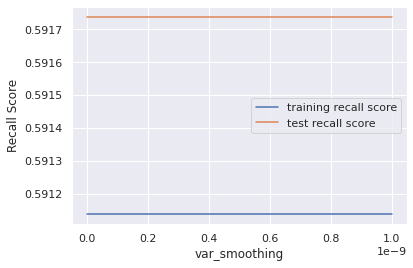

In [ ]:
# plotting recall scores with n_estimators
plt.figure()
plt.plot(gs_scores["param_var_smoothing"], 
         gs_scores["mean_train_score"], 
         label="training recall score")
plt.plot(gs_scores["param_var_smoothing"], 
         gs_scores["mean_test_score"], 
         label="test recall score")
plt.xlabel("var_smoothing")
plt.ylabel("Recall Score")
plt.legend()
plt.show()

In [ ]:
gs.best_params_

{'var_smoothing': 1e-12}

In [ ]:
gauss_nb_opt = GaussianNB(var_smoothing=1e-12)

In [ ]:
gauss_nb_opt.fit(X_train_tsvd, y_train_res)

GaussianNB(priors=None, var_smoothing=1e-12)

In [ ]:
y_test_pred_gs_opt = gauss_nb_opt.predict(X_test_svd)
y_train_pred_gs_opt = gauss_nb_opt.predict(X_train_tsvd)

In [ ]:
# checking accuracy, recall and f1 scores on training data
x = accuracy_score(y_train_res, y_train_pred_gs_opt)
y = recall_score(y_train_res, y_train_pred_gs_opt)
z = f1_score(y_train_res, y_train_pred_gs_opt)
print('training metric - accuracy ={}, recall={}, f1 score={}'.format(x,y,z))

training metric - accuracy =0.7235909735092119, recall=0.5837784803226862, f1 score=0.6786642164628351


In [ ]:
# checking accuracy, recall and f1 scores on test data
x = accuracy_score(y_test, y_test_pred_gs_opt)
y = recall_score(y_test, y_test_pred_gs_opt)
z = f1_score(y_test, y_test_pred_gs_opt)
print('test metric - accuracy ={}, recall={}, f1 score={}'.format(x,y,z))

test metric - accuracy =0.5856160523052644, recall=0.6263638670388226, f1 score=0.7287084870848709


#### Model Selection
1. **Logistic Regression**:
    This was tuned for hyperparameter and it gave us f1_score of around 94.1%
2. **Random Forest**:
    For this we are able to get an f1-score of 90%. Hyper-parameter tuning in terms of n_estimators has been quite computationally expensive.
3. **Naive Bayes Classifier**:
    We tried Bernoulli and Gaussian Based NBs. Most likely we faced a problem of underfitting as accuracies were poor on training data and no significant imporovement in metrics over test data was observed even when hyper-parameters were tuned. This is not working in our case.

> #### Clearly Logistic regression is our best bet amongst all the three models which had 94% accuracy, simpler to implement and was able to be improved upon using hyper-parameter tuning
> #### We have already saved our optimal logistic regression model to external file




# Building Recommendation System


*   User-based recommendation system
*   Item-based recommendation system



### User-Based Recommendation System

We will use df_master_2 as our final dataset to operate upon as it had preprocessed review text added as column

In [ ]:
df_master_2

,reviews_doRecommend,reviews_rating,reviews_username,user_sentiment,name_brand,reviews_text,word_count
0,True,5,joshua,1,Pink Friday: Roman Reloaded Re-Up (w/dvd)|Universal Music,awesome love album good hip hop side current pop sound hype listen everyday gym give rat way metaphors crazy,19
1,True,5,dorothy w,1,Lundberg Organic Cinnamon Toast Rice Cakes|Lundberg,good good flavor review collect part promotion,7
2,True,5,dorothy w,1,Lundberg Organic Cinnamon Toast Rice Cakes|Lundberg,good good flavor,3
3,False,1,rebecca,0,K-Y Love Sensuality Pleasure Gel|K-Y,disappoint read review look buy one couple lubricants ultimately disappoint didnt even live review read starters neither boyfriend nor could notic...,57
4,False,1,walker557,0,K-Y Love Sensuality Pleasure Gel|K-Y,irritation husband buy gel us gel cause irritation felt like burn skin wouldnt recommend gel,15
...,...,...,...,...,...,...,...
29932,True,5,laurasnchz,1,L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz|L'oreal Paris,softness get conditioner influenster try im love far oily hair use end hair feel amaze soft no mess review collect part promotion,22
29933,True,5,scarlepadilla,1,L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz|L'oreal Paris,love love receive review purpose influenster leave hair feel fresh smell great,12
29934,True,5,liviasuexo,1,L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz|L'oreal Paris,hair smooth use first love smell product wash hair smooth easy brush receive product influenster test purpose opinions review collect part promotion,22
29935,True,5,ktreed95,1,L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz|L'oreal Paris,perfect oily hair receive influenster never go back anything else normally dont use conditioner hair oily fine not make hair feel heavy doesnt get...,35


In [ ]:
df_ratings_1 = df_master_2[['reviews_username', 'name_brand', 'reviews_rating']]

In [ ]:
df_ratings_1

,reviews_username,name_brand,reviews_rating
0,joshua,Pink Friday: Roman Reloaded Re-Up (w/dvd)|Universal Music,5
1,dorothy w,Lundberg Organic Cinnamon Toast Rice Cakes|Lundberg,5
2,dorothy w,Lundberg Organic Cinnamon Toast Rice Cakes|Lundberg,5
3,rebecca,K-Y Love Sensuality Pleasure Gel|K-Y,1
4,walker557,K-Y Love Sensuality Pleasure Gel|K-Y,1
...,...,...,...
29932,laurasnchz,L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz|L'oreal Paris,5
29933,scarlepadilla,L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz|L'oreal Paris,5
29934,liviasuexo,L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz|L'oreal Paris,5
29935,ktreed95,L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz|L'oreal Paris,5


#### Let us create unique identifiers for our name_brand and reviews_username

In [ ]:
x = pd.unique(df_ratings_1['reviews_username'])

In [ ]:
list(enumerate(x, 1))

[(1, 'joshua'),
 (2, 'dorothy w'),
 (3, 'rebecca'),
 (4, 'walker557'),
 (5, 'samantha'),
 (6, 'raeanne'),
 (7, 'kimmie'),
 (8, 'cassie'),
 (9, 'moore222'),
 (10, 'jds1992'),
 (11, 'bre234'),
 (12, 'gordy313'),
 (13, 'nicole'),
 (14, 'cvperez'),
 (15, 'beccagrl532'),
 (16, 'sanchez'),
 (17, 'll24'),
 (18, 'browns fan'),
 (19, 'just faith everyday'),
 (20, 'vero'),
 (21, 'jo276'),
 (22, 'ashley a'),
 (23, 'jp71'),
 (24, 'jkell'),
 (25, 'karen'),
 (26, 'warren'),
 (27, 'mas0814'),
 (28, 'amanda'),
 (29, 'peach pie'),
 (30, 'birdwoman'),
 (31, 'michelle'),
 (32, 'jean z'),
 (33, 'vanessa mcnally'),
 (34, '5alarm'),
 (35, 'danielle'),
 (36, 'shedove'),
 (37, 'cynthiacc'),
 (38, 'dfwatheartgirl'),
 (39, 'crissyx5'),
 (40, 'nyisha m'),
 (41, 'gardenbunny318'),
 (42, 'solo'),
 (43, 'sasparilla'),
 (44, 'mkris18'),
 (45, 'momof2'),
 (46, 'mommyshappy8714'),
 (47, 'eyo'),
 (48, 'anonymous8589'),
 (49, 'jazzymom'),
 (50, 'ramona831'),
 (51, 'morgiana'),
 (52, 'alnscoob97'),
 (53, 'star33'),
 (54,

In [ ]:
y = dict(enumerate(x, 1))

In [ ]:
y[1]

'joshua'

In [ ]:
!pip install bidict

In [ ]:
from bidict import bidict

In [ ]:
username_bdct = bidict(dict(enumerate(x, 1)))

In [ ]:
username_bdct.inverse['rebecca']

3

In [ ]:
username_bdct[3]

'rebecca'

In [ ]:
# similariy lets create  bidirectional identifier mapping for name and brand
product_bdct = bidict(dict(enumerate(pd.unique(df_ratings_1['name_brand']), 1)))

In [ ]:
product_bdct[1]

'Pink Friday: Roman Reloaded Re-Up (w/dvd)|Universal Music'

In [ ]:
product_bdct.inverse['Pink Friday: Roman Reloaded Re-Up (w/dvd)|Universal Music']

1

Persisting username and product mappings

In [ ]:
joblib.dump(username_bdct, '/content/gdrive/MyDrive/Colab Notebooks/Sentiment Based Product Recommendation System/username_bidict.sav')

['/content/gdrive/MyDrive/Colab Notebooks/Sentiment Based Product Recommendation System/username_bidict.sav']

In [ ]:
joblib.dump(product_bdct, '/content/gdrive/MyDrive/Colab Notebooks/Sentiment Based Product Recommendation System/product_bidict.sav')

['/content/gdrive/MyDrive/Colab Notebooks/Sentiment Based Product Recommendation System/product_bidict.sav']

#### Now let us create user_id and product_id using enumerated mappings

In [ ]:
df_ratings_1['user_id'] = df_ratings_1['reviews_username'].apply(lambda x: username_bdct.inverse[x])

In [ ]:
df_ratings_1.head()

,reviews_username,name_brand,reviews_rating,user_id
0,joshua,Pink Friday: Roman Reloaded Re-Up (w/dvd)|Universal Music,5,1
1,dorothy w,Lundberg Organic Cinnamon Toast Rice Cakes|Lundberg,5,2
2,dorothy w,Lundberg Organic Cinnamon Toast Rice Cakes|Lundberg,5,2
3,rebecca,K-Y Love Sensuality Pleasure Gel|K-Y,1,3
4,walker557,K-Y Love Sensuality Pleasure Gel|K-Y,1,4


In [ ]:
# doing the same for product name
df_ratings_1['product_id'] = df_ratings_1['name_brand'].apply(lambda x: product_bdct.inverse[x])

In [ ]:
df_ratings_1.head()

,reviews_username,name_brand,reviews_rating,user_id,product_id
0,joshua,Pink Friday: Roman Reloaded Re-Up (w/dvd)|Universal Music,5,1,1
1,dorothy w,Lundberg Organic Cinnamon Toast Rice Cakes|Lundberg,5,2,2
2,dorothy w,Lundberg Organic Cinnamon Toast Rice Cakes|Lundberg,5,2,2
3,rebecca,K-Y Love Sensuality Pleasure Gel|K-Y,1,3,3
4,walker557,K-Y Love Sensuality Pleasure Gel|K-Y,1,4,3


#### Dividing the dataset into train and test

In [ ]:
# Test and Train split of the dataset.
from sklearn.model_selection import train_test_split
rc_train, rc_test = train_test_split(df_ratings_1, test_size=0.30, random_state=31)

In [ ]:
print(rc_train.shape)
print(rc_test.shape)

(20697, 5)
(8871, 5)


### Creating dummy train & dummy test dataset
These dataset will be used for prediction 
- Dummy train will be used later for prediction of the products which has not been rated by the user. To ignore the products rated by the user, we will mark it as 0 during prediction. The products not rated by user is marked as 1 for prediction in dummy train dataset. 

- In marking the products information for rating would be lost in dummy datasets but that is okay as we have a different purpose here

- Dummy test will be used for evaluation. To evaluate, we will only make prediction on the products rated by the user. So, this is marked as 1. 
- `This is just opposite of dummy_train.`

In [ ]:
# Copy the train dataset into dummy_train
dummy_train = rc_train.copy()

In [ ]:
dummy_train

,reviews_username,name_brand,reviews_rating,user_id,product_id
21196,roba,Nexxus Exxtra Gel Style Creation Sculptor|Nexxus,1,17938,203
18692,tooney38,Clorox Disinfecting Bathroom Cleaner|Clorox,4,6097,182
19930,jenc227,Clorox Disinfecting Bathroom Cleaner|Clorox,5,17152,182
25088,mwheeler1324,Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd|Warner Home Video,5,20867,227
9776,munkygurl101,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total|Clorox,5,8950,90
...,...,...,...,...,...
3790,admin in williamsburg,"Pendaflex174 Divide It Up File Folder, Multi Section, Letter, Assorted, 12/pack|Pendaflex",2,3460,68
15063,maggieb123,"Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter|Avery",5,13533,91
27841,miss,Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd)|Disney,5,23108,248
26960,jimmyjames59,Jason Aldean - They Don't Know|Warner Music Group,5,22403,240


In [ ]:
# The products not rated by user is marked as 1 for prediction. rating goes from 1 to 5
dummy_train['reviews_rating'] = dummy_train['reviews_rating'].apply(lambda x: 0 if x>=1 else 1)

In [ ]:
dummy_train

,reviews_username,name_brand,reviews_rating,user_id,product_id
21196,roba,Nexxus Exxtra Gel Style Creation Sculptor|Nexxus,0,17938,203
18692,tooney38,Clorox Disinfecting Bathroom Cleaner|Clorox,0,6097,182
19930,jenc227,Clorox Disinfecting Bathroom Cleaner|Clorox,0,17152,182
25088,mwheeler1324,Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd|Warner Home Video,0,20867,227
9776,munkygurl101,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total|Clorox,0,8950,90
...,...,...,...,...,...
3790,admin in williamsburg,"Pendaflex174 Divide It Up File Folder, Multi Section, Letter, Assorted, 12/pack|Pendaflex",0,3460,68
15063,maggieb123,"Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter|Avery",0,13533,91
27841,miss,Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd)|Disney,0,23108,248
26960,jimmyjames59,Jason Aldean - They Don't Know|Warner Music Group,0,22403,240


In [ ]:
# Convert the dummy train dataset into matrix format. since we are using
# 1 to determine not rated we will fill NA by 1 too
dummy_train = dummy_train.pivot_table(
    index='user_id',
    columns='product_id',
    values='reviews_rating'
).fillna(1)

In [ ]:
dummy_train

product_id,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,39,40,41,...,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
5,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24621,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
24622,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
24623,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0


**Now the cells where we have 0s do not need attention but the ones with 1 in them are to be targeted for prediction later**

**Adjusted Cosine**

Adjusted cosine similarity is a modified version of vector-based similarity where we incorporate the fact that different users have different ratings schemes. In other words, some users might rate items highly in general, and others might give items lower ratings as a preference. To handle this nature from rating given by user , we subtract average ratings for each user from each user's rating for different movies.

#### Pivot the training ratings dataset into matrix format



In [ ]:
# Create a user-movie matrix.
df_pivot = rc_train.pivot_table(
    index='user_id',
    columns='product_id',
    values='reviews_rating'
)

In [ ]:
df_pivot.head()

product_id,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,39,40,41,...,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,1.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Normalising the rating of the product for each user around 0 mean

In [ ]:
mean = np.nanmean(df_pivot, axis=1)
df_subtracted = (df_pivot.T-mean).T

In [ ]:
df_subtracted.head()

product_id,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,39,40,41,...,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.4,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,-3.000000,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,-2.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.333333,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### Finding cosine similarity

In [ ]:
from sklearn.metrics.pairwise import pairwise_distances

In [ ]:
# Creating the User Similarity Matrix using pairwise_distance function.
user_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')

In [ ]:
user_correlation[0][user_correlation[0] > 0.5]

array([1.        , 0.55339859, 0.55339859, 0.55339859, 0.55339859,
       0.63900965, 0.63900965])

In [ ]:
# checking users negatively related
user_correlation[0][user_correlation[0] < 0]

array([-0.03022443, -0.05328672, -0.09128709, -0.02438238, -0.05      ,
       -0.06454972, -0.04082483, -0.08029551, -0.09128709, -0.31950483,
       -0.12076147, -0.67777209, -0.55339859, -0.55339859, -0.55339859,
       -0.39528471, -0.22592403, -0.31950483, -0.06454972, -0.04082483,
       -0.03450328, -0.18257419, -0.10112998, -0.06454972, -0.15811388,
       -0.15811388, -0.15811388, -0.15811388, -0.15811388, -0.15811388,
       -0.15811388, -0.06454972, -0.15811388, -0.09128709])

In [ ]:
# in our case there is no NaN valye
sum(sum(np.isnan(user_correlation)))

0

In [ ]:
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
user_correlation.shape

(18091, 18091)

Let us pick a user cassie and check what should be recommended to him

#### Prediction - User User

Doing the prediction for the users which are positively related with other users, and not the users which are negatively related as we are interested in the users which are more similar to the current users. So, ignoring the correlation for values less than 0. 

In [ ]:
user_correlation[user_correlation<0]=0
user_correlation

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
df_pivot.shape

(18091, 259)

Rating predicted by the user (for product rated as well as not rated) is the weighted sum of correlation with the product rating (as present in the rating dataset). 

In [ ]:
user_predicted_ratings = np.dot(user_correlation, df_pivot.fillna(0))
user_predicted_ratings

array([[5.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 2.87625405, ..., 0.        , 0.43643578,
        0.94491118],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [ ]:
user_predicted_ratings.shape

(18091, 259)

Since we are interested only in the products not rated by the user, we will ignore the products rated by the user by making it zero. 

Also mutliplication with dummy_train will ensure all the user_product_ids appear in the result of the operation so that we can use the product id as an input

In [ ]:
user_final_rating = np.multiply(user_predicted_ratings,dummy_train)
user_final_rating.head()

product_id,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,39,40,41,...,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.948683,0.790569,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,3.198330,0.0,2.143304,0.0,...,0.0,0.456435,1.424810,0.0,0.000000,0.0,0.0,0.684653,0.0,0.000000,0.000000,0.0,0.634240,0.0,0.0,0.0,0.000000,1.424810,4.478686,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.806805,0.0,0.0,0.0,0.755929,0.731925,1.362268,0.0,0.243975,0.0,0.0,0.0,0.308607,0.0,0.475493,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.109109,0.298807,0.0,0.0,2.356916,0.0,13.785222,0.0,0.000000,0.0,...,0.0,0.771517,2.040529,0.0,0.918066,0.0,0.0,0.000000,0.0,3.273268,1.866174,0.0,0.689147,0.0,0.0,0.0,0.957938,1.213084,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.792981,0.475493,0.0,0.357143,0.0,0.0,0.436436,0.944911
4,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000
5,0.0,0.0,0.0,0.0,0.0,0.0,3.273268,0.117851,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,1.737559,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.184900,0.456435,0.0,0.000000,0.0,0.0,0.666667,0.0,3.333333,3.640135,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,9.076833,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.589256,0.46225,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,1.154701


#### Finding the top 20 recommendation for the *user*

In [ ]:
# Take the user ID as input.
user_input = str(input("Enter your user name"))
user_input_id = username_bdct.inverse[user_input]
print(user_input_id)

Enter your user namesamantha
5


In [ ]:
d = user_final_rating.loc[user_input_id].sort_values(ascending=False)[0:20]
d

product_id
227    15.278726
248     9.076833
90      8.741331
42      7.989910
202     5.010828
182     4.492510
240     3.640135
99      3.516692
239     3.333333
72      3.333333
7       3.273268
79      3.130546
87      2.809049
88      2.195086
35      1.737559
68      1.718555
91      1.180223
206     1.178511
269     1.154701
136     1.154701
Name: 5, dtype: float64

We can use prodcut_bdct to get the name of the products

In [ ]:
[product_bdct[x] for x in d.index]

['Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd|Warner Home Video',
 'Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd)|Disney',
 'Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total|Clorox',
 'My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Digital)|Universal Home Video',
 'Tostitos Bite Size Tortilla Chips|Tostitos',
 'Clorox Disinfecting Bathroom Cleaner|Clorox',
 "Jason Aldean - They Don't Know|Warner Music Group",
 "Burt's Bees Lip Shimmer, Raisin|Burt's Bees",
 'Boraam Sonoma Kitchen Cart With Wire Brush Gray - Maaya Home|Maaya Home',
 'Hoover174 Platinum Collection153 Lightweight Bagged Upright Vacuum With Canister - Uh30010com|Hoover',
 'Olay Regenerist Deep Hydration Regenerating Cream|Olay',
 'The Resident Evil Collection 5 Discs (blu-Ray)|Sony Pictures',
 'Red (special Edition) (dvdvideo)|Summit Entertainment',
 'Hormel Chili, No Beans|Hormel',
 'Dark Shadows (includes Digital Copy) (ultraviolet) (dvdvideo)|Warner Bros.',
 'Pendaflex174 

In [ ]:
# creating a class wrapper for user based recommender model

In [ ]:
class UserBasedRecommender:
  '''
  A class to encapsulate User Based Recommendation System for persistence
  '''
  def __init__(self, user_rating_matrix):
    self.user_rating_matrix = user_rating_matrix
  
  def recommend_top_20_products(self, user_input_id):
    return self.user_rating_matrix.loc[user_input_id].sort_values(ascending=False)[0:20]


In [ ]:
user_based_recommender = UserBasedRecommender(user_final_rating)

In [ ]:
user_based_recommender.recommend_top_20_products(5)

product_id
227    15.278726
248     9.076833
90      8.741331
42      7.989910
202     5.010828
182     4.492510
240     3.640135
99      3.516692
239     3.333333
72      3.333333
7       3.273268
79      3.130546
87      2.809049
88      2.195086
35      1.737559
68      1.718555
91      1.180223
206     1.178511
269     1.154701
136     1.154701
Name: 5, dtype: float64

#### Persisting User Based Recommender model

In [ ]:
import joblib
joblib.dump(user_based_recommender, '/content/gdrive/MyDrive/Colab Notebooks/Sentiment Based Product Recommendation System/user_based_recommender.sav')

['/content/gdrive/MyDrive/Colab Notebooks/Sentiment Based Product Recommendation System/user_based_recommender.sav']

### Evaluation - User User 

To evaluate we would need what is actual and what is predicted. As to find the error we need the difference of two. In this case what we can do is find prediction for those review ratings which already exist. This would require also finding the common user in our test and train dataset.</br>
As training data would provide the actual ratings for those common users and then we can predict. Later Root Mean Sqaure Error can be computed. </br>
Same would apply for test data

In [ ]:
# Find out the common users of test and train dataset.
common = rc_test[rc_test.user_id.isin(rc_train.user_id)]
common.shape

(2043, 5)

We have 2043 users in common.

In [ ]:
common.head()

,reviews_username,name_brand,reviews_rating,user_id,product_id
9090,nance,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total|Clorox,5,8293,90
29247,sammypm,L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz|L'oreal Paris,4,24221,269
28923,gabbyf7,L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz|L'oreal Paris,3,23910,269
12621,aryalynn,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total|Clorox,5,8568,90
12432,dts976,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total|Clorox,5,11245,90


In [ ]:
# convert into the user-product matrix.
common_user_based_matrix = common.pivot_table(index='user_id', columns='product_id', values='reviews_rating')

In [ ]:
common_user_based_matrix

product_id,3,6,7,8,10,12,13,16,20,21,22,24,25,29,30,35,37,40,41,42,44,45,47,54,55,56,60,61,64,66,67,68,70,72,73,78,79,81,82,83,...,186,187,190,196,199,200,202,203,206,208,212,213,217,219,220,221,222,224,225,227,231,232,234,237,239,240,242,243,244,247,248,249,251,252,257,258,259,262,268,269
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24282,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0
24283,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0
24299,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0


In [ ]:
# Convert the user_correlation matrix into dataframe.
user_correlation_df = pd.DataFrame(user_correlation)

In [ ]:
df_subtracted.head(1)

product_id,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,39,40,41,...,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.4,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
user_correlation_df['userId'] = df_subtracted.index
user_correlation_df.set_index('userId',inplace=True)
user_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,18051,18052,18053,18054,18055,18056,18057,18058,18059,18060,18061,18062,18063,18064,18065,18066,18067,18068,18069,18070,18071,18072,18073,18074,18075,18076,18077,18078,18079,18080,18081,18082,18083,18084,18085,18086,18087,18088,18089,18090
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.000000,0.0,0.654654,0.0,0.566947,0.0,0.0,0.0,0.0,0.654654,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.654654,0.0,1.000000,0.0,0.577350,0.0,0.0,0.0,0.0,0.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
list_name = common.user_id.tolist()

user_correlation_df.columns = df_subtracted.index.tolist()


user_correlation_df_1 =  user_correlation_df[user_correlation_df.index.isin(list_name)]

In [ ]:
user_correlation_df_1.shape

(1707, 18091)

In [ ]:
user_correlation_df_2 = user_correlation_df_1.T[user_correlation_df_1.T.index.isin(list_name)]

In [ ]:
user_correlation_df_3 = user_correlation_df_2.T

In [ ]:
user_correlation_df_3.head()

,3,5,7,8,10,13,25,28,31,35,45,73,75,127,188,189,191,269,287,290,313,356,401,412,491,575,594,595,605,636,676,681,682,688,698,721,723,725,753,767,...,24213,24214,24217,24218,24219,24220,24221,24225,24231,24235,24236,24237,24241,24242,24243,24244,24245,24246,24248,24249,24250,24253,24254,24255,24256,24257,24258,24261,24263,24264,24267,24268,24271,24274,24275,24282,24283,24299,24310,24320
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3,1.000000,0.654654,0.566947,0.0,0.0,0.654654,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.077152,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.188982,0.0,0.0,0.0,0.108375,0.077152,0.0,0.146385,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.654654,1.000000,0.577350,0.0,0.0,0.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.117851,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.566947,0.577350,1.000000,0.0,0.0,0.577350,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
user_correlation_df_3.shape

(1707, 1707)

In [ ]:
user_correlation_df_3[user_correlation_df_3<0]=0

common_user_predicted_ratings = np.dot(user_correlation_df_3, common_user_based_matrix.fillna(0))
common_user_predicted_ratings

array([[0.        , 0.        , 0.        , ..., 0.        , 5.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 3.27326835,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 2.83473355,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [ ]:
dummy_test = common.copy()

dummy_test['reviews_rating'] = dummy_test['reviews_rating'].apply(lambda x: 1 if x>=1 else 0)

dummy_test = dummy_test.pivot_table(index='user_id', columns='product_id', values='reviews_rating').fillna(0)

In [ ]:
dummy_test.shape

(1707, 125)

In [ ]:
common_user_predicted_ratings = np.multiply(common_user_predicted_ratings,dummy_test)

In [ ]:
common_user_predicted_ratings.head(2)

product_id,3,6,7,8,10,12,13,16,20,21,22,24,25,29,30,35,37,40,41,42,44,45,47,54,55,56,60,61,64,66,67,68,70,72,73,78,79,81,82,83,...,186,187,190,196,199,200,202,203,206,208,212,213,217,219,220,221,222,224,225,227,231,232,234,237,239,240,242,243,244,247,248,249,251,252,257,258,259,262,268,269
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.383615,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Calculating the RMSE for only the products rated by user. For RMSE, normalising the rating to (1,5) range.

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from numpy import *

X  = common_user_predicted_ratings.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(copy=True, feature_range=(1, 5))
[[nan nan nan ... nan  1. nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [ ]:
common_1 = common.pivot_table(index='user_id', columns='product_id', values='reviews_rating')

In [ ]:
common_1.head()

product_id,3,6,7,8,10,12,13,16,20,21,22,24,25,29,30,35,37,40,41,42,44,45,47,54,55,56,60,61,64,66,67,68,70,72,73,78,79,81,82,83,...,186,187,190,196,199,200,202,203,206,208,212,213,217,219,220,221,222,224,225,227,231,232,234,237,239,240,242,243,244,247,248,249,251,252,257,258,259,262,268,269
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

In [ ]:
rmse = (sum(sum((common_1 - y )**2))/total_non_nan)**0.5
print(rmse)

2.436635518306648


### Item-Based Recommendation System

**Item Based Similarity**  
Taking the transpose of the rating matrix to normalize the rating around the mean for different product ID. In the user based similarity, we had taken mean for each user instead of each product. 

In [ ]:
df_pivot_1 = rc_train.pivot_table(
    index='user_id',
    columns='product_id',
    values='reviews_rating'
).T

df_pivot_1.head()

user_id,1,2,3,4,5,6,7,8,9,10,11,13,14,16,17,18,19,20,21,23,24,25,27,28,30,31,32,33,34,35,36,37,38,40,41,42,43,44,45,46,...,24566,24567,24568,24570,24572,24573,24574,24576,24577,24578,24579,24580,24581,24582,24584,24585,24586,24589,24590,24592,24594,24595,24597,24598,24600,24601,24606,24608,24609,24611,24612,24613,24614,24618,24620,24621,24622,24623,24624,24625
product_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,1.0,1.0,1.0,1.0,1.0,NaN,1.0,1.0,1.0,1.0,1.0,1.0,3.0,3.0,4.0,4.0,4.0,5.0,5.0,5.0,5.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,5.0,5.0,5.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,5.0,5.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Normalising the review rating for each product for using the Adujsted Cosine

In [ ]:
mean_1 = np.nanmean(df_pivot_1, axis=1)
df_subtracted_1 = (df_pivot_1.T - mean_1).T

In [ ]:
df_subtracted.head()

product_id,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,39,40,41,...,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.4,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,-3.000000,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,-2.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.333333,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Finding the cosine similarity using pairwise distances approach

In [ ]:
from sklearn.metrics.pairwise import pairwise_distances

In [ ]:
# Item Similarity Matrix
item_correlation = 1 - pairwise_distances(df_subtracted_1.fillna(0), metric='cosine')
item_correlation[np.isnan(item_correlation)] = 0
print(item_correlation)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


Filtering the correlation only for which the value is greater than 0. (Positively correlated)

In [ ]:
item_correlation[item_correlation<0]=0
item_correlation

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

#### Prediction - Item Item

In [ ]:
item_predicted_ratings = np.dot((df_pivot_1.fillna(0).T), item_correlation)
item_predicted_ratings

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.01454178],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 1.07094092, ..., 0.        , 0.        ,
        0.01881089],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        5.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        5.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        5.        ]])

In [ ]:
item_predicted_ratings.shape

(18091, 259)

In [ ]:
dummy_train.shape

(18091, 259)

#### Filtering the rating only for the movies not rated by the user for recommendation

In [ ]:
item_final_rating = np.multiply(item_predicted_ratings,dummy_train)
item_final_rating.head()

product_id,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,39,40,41,...,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.002693,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.010711,0.0,0.0,0.0,0.000000,0.033365,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.027754,0.022118,0.000000,0.0,0.000000,0.0,0.023437,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.041526,0.0,0.000000,0.028892,0.0,0.000000,0.0,0.0,0.0,0.0,0.010024,0.016416,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.014542
2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.133221,0.0,0.0,0.0,0.001691,0.002899,0.021018,0.0,0.014772,0.0,0.0,0.0,0.044268,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.006547,0.018807,0.005236,0.0,0.008856,0.0,0.040317,0.0,0.0,0.0,...,0.0,0.008529,0.027031,0.0,0.000000,0.0,0.0,0.000000,0.0,0.528015,0.049660,0.0,0.013279,0.0,0.0,0.0,0.0,0.005820,0.000000,0.00833,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.001327,0.017257,0.0,0.0,0.0,0.010976,0.0,0.065371,0.005706,0.0,0.0,0.018811
4,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000
5,0.0,0.0,0.0,0.0,0.0,0.0,0.004544,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.020302,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.031237,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.041234,0.0,0.005949,0.0,0.0,0.000000,0.0,0.000000,0.035090,0.0,0.002753,0.0,0.0,0.0,0.0,0.002950,0.000265,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.040604,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000


#### Finding the top 20 recommendation for the *user*

In [ ]:
# Take the user ID as input.
user_input = str(input("Enter your user name"))
user_input_id = username_bdct.inverse[user_input]
print(user_input_id)

Enter your user namesamantha
5


In [ ]:
# Recommending the Top 20 products to the user.
d_1 = item_final_rating.loc[user_input_id].sort_values(ascending=False)[0:20]
d_1

product_id
140    1.977513
160    0.074313
121    0.074132
92     0.074132
72     0.063751
79     0.051888
42     0.049294
136    0.044584
232    0.041234
202    0.041124
226    0.041121
148    0.040604
257    0.040604
177    0.037592
118    0.037359
240    0.035090
88     0.033760
57     0.033488
83     0.033358
200    0.032754
Name: 5, dtype: float64

In [ ]:
[product_bdct[x] for x in d_1.index]

['Black Front Loading Frame Set (8.5x11) Set Of 12|Nielsen',
 'Pleasant Hearth Diamond Fireplace Screen - Espresso|Pleasant Hearth',
 'Kind Nut Delight Bar|KIND',
 "Chips Deluxe Soft 'n Chewy Cookies|Chips Deluxe",
 'Hoover174 Platinum Collection153 Lightweight Bagged Upright Vacuum With Canister - Uh30010com|Hoover',
 'The Resident Evil Collection 5 Discs (blu-Ray)|Sony Pictures',
 'My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Digital)|Universal Home Video',
 "There's Something About Mary (dvd)|FOX",
 "Stargate (ws) (ultimate Edition) (director's Cut) (dvdvideo)|Lionsgate",
 'Tostitos Bite Size Tortilla Chips|Tostitos',
 'Olivella Bar Soap - 3.52 Oz|Olivella',
 "Newman's Own Balsamic Vinaigrette, 16.0oz|Newman's Own",
 "Musselman Apple Sauce, Cinnamon, 48oz|Musselman's",
 'Ogx Conditioner, Hydrating Teatree Mint|Ogx',
 'Mill Creek Aloe Vera & Paba Lotion|Mill Creek',
 "Jason Aldean - They Don't Know|Warner Music Group",
 'Hormel Chili, No Beans|Hormel',
 'Tresemme Kertatin Smooth Infus

### Evaluation - Item Item 

In [ ]:
rc_test.columns

Index(['reviews_username', 'name_brand', 'reviews_rating', 'user_id',
       'product_id'],
      dtype='object')

In [ ]:
# Find out the common products of test and train dataset.
common_2 = rc_test[rc_test.product_id.isin(rc_train.product_id)]
common_2.shape

(8860, 5)

In [ ]:
common_2.head()

,reviews_username,name_brand,reviews_rating,user_id,product_id
132,6623443094,Olay Regenerist Deep Hydration Regenerating Cream|Olay,4,128,7
5902,skycat,Red (special Edition) (dvdvideo)|Summit Entertainment,5,5319,87
12276,kmin,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total|Clorox,5,8719,90
16951,bymountain view,"Lundberg Wehani Rice, 25lb|Lundberg",5,15191,108
10577,twinky,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total|Clorox,5,9650,90


In [ ]:
common_item_based_matrix = common_2.pivot_table(index='user_id', columns='product_id', values='reviews_rating').T

In [ ]:
common_item_based_matrix.shape

(195, 8232)

In [ ]:
item_correlation_df = pd.DataFrame(item_correlation)

In [ ]:
item_correlation_df['product_id'] = df_subtracted_1.index
item_correlation_df.set_index('product_id',inplace=True)
item_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258
product_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
list_name = common_2.product_id.tolist()

In [ ]:
item_correlation_df.columns = df_subtracted_1.index.tolist()

item_correlation_df_1 =  item_correlation_df[item_correlation_df.index.isin(list_name)]

In [ ]:
item_correlation_df_2 = item_correlation_df_1.T[item_correlation_df_1.T.index.isin(list_name)]

item_correlation_df_3 = item_correlation_df_2.T

In [ ]:
item_correlation_df_3.head()

,3,4,6,7,8,10,11,12,13,14,15,16,20,21,22,24,25,29,30,31,33,35,36,37,40,41,42,44,45,47,49,54,55,56,57,59,60,61,62,64,...,217,218,219,220,221,222,224,225,227,228,229,231,232,234,236,237,238,239,240,241,242,243,244,246,247,248,249,251,252,256,257,258,259,262,263,264,266,267,268,269
product_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.005069,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.001271,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.003578,0.0,0.0,0.000702,0.0,0.0,0.0,0.003371,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.001164,0.000418,0.001666,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000898,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.006721,0.0,0.0,0.0,0.0,...,0.003173,0.0,0.0,0.0,0.0,0.011563,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.061048,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
item_correlation_df_3[item_correlation_df_3<0]=0

common_item_predicted_ratings = np.dot(item_correlation_df_3, common_item_based_matrix.fillna(0))
common_item_predicted_ratings

array([[0.        , 0.        , 0.02027794, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [5.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 5.        , 5.        ,
        5.        ]])

In [ ]:
common_item_predicted_ratings.shape

(195, 8232)

Dummy test will be used for evaluation. To evaluate, we will only make prediction on the product rated by the user. So, this is marked as 1. This is just opposite of dummy_train



In [ ]:
dummy_test = common_2.copy()

dummy_test['reviews_rating'] = dummy_test['reviews_rating'].apply(lambda x: 1 if x>=1 else 0)

dummy_test = dummy_test.pivot_table(index='user_id', columns='product_id', values='reviews_rating').T.fillna(0)

common_item_predicted_ratings = np.multiply(common_item_predicted_ratings,dummy_test)

The products not rated is marked as 0 for evaluation. And make the item- item matrix representaion.


In [ ]:
common_3 = common_2.pivot_table(index='user_id', columns='product_id', values='reviews_rating').T

In [ ]:
common_3.shape

(195, 8232)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from numpy import *

X  = common_item_predicted_ratings.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(copy=True, feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [ 1. nan nan ... nan nan nan]
 [nan nan nan ...  1.  1.  1.]]


In [ ]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

In [ ]:
rmse = (sum(sum((common_3 - y )**2))/total_non_nan)**0.5
print(rmse)

3.549214513266457


### Recommendation System Selection
> #### RMSE for User Based Recommendation System is 2.434
> #### RMSE for Item Based Recommendation System is 3.548
> #### Hence We will go with `User Based Recommendation System`

# Fine-Tuning the Recommendation System and Recommendation of Top 5 Products

Since we chose the User based recommendation System. We will take top 20 products recommended in that section and further refine the recommendation using percentage sentiment

In [ ]:
d.index

Int64Index([227, 248,  90,  42, 202, 182, 240,  99, 239,  72,   7,  79,  87,
             88,  35,  68,  91, 206, 269, 136],
           dtype='int64', name='product_id')

In [ ]:
usr_based_top_20 = [(x, product_bdct[x]) for x in d.index]

In [ ]:
usr_based_top_20

[(227,
  'Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd|Warner Home Video'),
 (248,
  'Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd)|Disney'),
 (90, 'Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total|Clorox'),
 (42,
  'My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Digital)|Universal Home Video'),
 (202, 'Tostitos Bite Size Tortilla Chips|Tostitos'),
 (182, 'Clorox Disinfecting Bathroom Cleaner|Clorox'),
 (240, "Jason Aldean - They Don't Know|Warner Music Group"),
 (99, "Burt's Bees Lip Shimmer, Raisin|Burt's Bees"),
 (239,
  'Boraam Sonoma Kitchen Cart With Wire Brush Gray - Maaya Home|Maaya Home'),
 (72,
  'Hoover174 Platinum Collection153 Lightweight Bagged Upright Vacuum With Canister - Uh30010com|Hoover'),
 (7, 'Olay Regenerist Deep Hydration Regenerating Cream|Olay'),
 (79, 'The Resident Evil Collection 5 Discs (blu-Ray)|Sony Pictures'),
 (87, 'Red (special Edition) (dvdvideo)|Summit Entertainment'),
 (88, 'Hormel Chili, No Beans|Horme

Till now we have been creating purpose oriented tables.  
`df_ratings_1` for recommendation system, as we needed to create identifiers for products and users
`df_master_2` - this is what we obtained after text preprocessing - it holds all the required information  
What we will do is create another `df_master_3` that will be a smart merge of the two and export it to csv file. This will eventually be used as a base data set for our backend service.

In [ ]:
df_ratings_1

,reviews_username,name_brand,reviews_rating,user_id,product_id
0,joshua,Pink Friday: Roman Reloaded Re-Up (w/dvd)|Universal Music,5,1,1
1,dorothy w,Lundberg Organic Cinnamon Toast Rice Cakes|Lundberg,5,2,2
2,dorothy w,Lundberg Organic Cinnamon Toast Rice Cakes|Lundberg,5,2,2
3,rebecca,K-Y Love Sensuality Pleasure Gel|K-Y,1,3,3
4,walker557,K-Y Love Sensuality Pleasure Gel|K-Y,1,4,3
...,...,...,...,...,...
29932,laurasnchz,L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz|L'oreal Paris,5,24621,269
29933,scarlepadilla,L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz|L'oreal Paris,5,24622,269
29934,liviasuexo,L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz|L'oreal Paris,5,24623,269
29935,ktreed95,L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz|L'oreal Paris,5,24624,269


In [ ]:
df_master_2

,reviews_doRecommend,reviews_rating,reviews_username,user_sentiment,name_brand,reviews_text,word_count
0,True,5,joshua,1,Pink Friday: Roman Reloaded Re-Up (w/dvd)|Universal Music,awesome love album good hip hop side current pop sound hype listen everyday gym give rat way metaphors crazy,19
1,True,5,dorothy w,1,Lundberg Organic Cinnamon Toast Rice Cakes|Lundberg,good good flavor review collect part promotion,7
2,True,5,dorothy w,1,Lundberg Organic Cinnamon Toast Rice Cakes|Lundberg,good good flavor,3
3,False,1,rebecca,0,K-Y Love Sensuality Pleasure Gel|K-Y,disappoint read review look buy one couple lubricants ultimately disappoint didnt even live review read starters neither boyfriend nor could notic...,57
4,False,1,walker557,0,K-Y Love Sensuality Pleasure Gel|K-Y,irritation husband buy gel us gel cause irritation felt like burn skin wouldnt recommend gel,15
...,...,...,...,...,...,...,...
29932,True,5,laurasnchz,1,L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz|L'oreal Paris,softness get conditioner influenster try im love far oily hair use end hair feel amaze soft no mess review collect part promotion,22
29933,True,5,scarlepadilla,1,L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz|L'oreal Paris,love love receive review purpose influenster leave hair feel fresh smell great,12
29934,True,5,liviasuexo,1,L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz|L'oreal Paris,hair smooth use first love smell product wash hair smooth easy brush receive product influenster test purpose opinions review collect part promotion,22
29935,True,5,ktreed95,1,L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz|L'oreal Paris,perfect oily hair receive influenster never go back anything else normally dont use conditioner hair oily fine not make hair feel heavy doesnt get...,35


In [ ]:
df_master_3 = df_master_2.copy()
df_master_3['user_id'] = df_ratings_1['user_id']
df_master_3['product_id'] = df_ratings_1['product_id']
df_master_3.head()

,reviews_doRecommend,reviews_rating,reviews_username,user_sentiment,name_brand,reviews_text,word_count,user_id,product_id
0,True,5,joshua,1,Pink Friday: Roman Reloaded Re-Up (w/dvd)|Universal Music,awesome love album good hip hop side current pop sound hype listen everyday gym give rat way metaphors crazy,19,1,1
1,True,5,dorothy w,1,Lundberg Organic Cinnamon Toast Rice Cakes|Lundberg,good good flavor review collect part promotion,7,2,2
2,True,5,dorothy w,1,Lundberg Organic Cinnamon Toast Rice Cakes|Lundberg,good good flavor,3,2,2
3,False,1,rebecca,0,K-Y Love Sensuality Pleasure Gel|K-Y,disappoint read review look buy one couple lubricants ultimately disappoint didnt even live review read starters neither boyfriend nor could notic...,57,3,3
4,False,1,walker557,0,K-Y Love Sensuality Pleasure Gel|K-Y,irritation husband buy gel us gel cause irritation felt like burn skin wouldnt recommend gel,15,4,3


#### Saving Final master_data set

In [ ]:
# df_master_3.to_csv("/content/gdrive/MyDrive/Colab Notebooks/Sentiment Based Product Recommendation System/master_data.csv", index=False)

#### Importing saved model

In [ ]:
import joblib

In [ ]:
lgr_pipeline = joblib.load('/content/gdrive/MyDrive/Colab Notebooks/Sentiment Based Product Recommendation System/logistic_user_sentiment_classifer_pipeline.sav')

In [ ]:
type(lgr_pipeline)

__main__.LRModel

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

#### Sentiment Prediction for products using reviews_text

In [ ]:
# let us check review_text for one such product id
master_data = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/Sentiment Based Product Recommendation System/master_data.csv")

In [ ]:
master_data.dropna(inplace=True)

In [ ]:
master_data.reset_index(drop=True, inplace=True)

In [ ]:
master_data.head()

,reviews_doRecommend,reviews_rating,reviews_username,user_sentiment,name_brand,reviews_text,word_count,user_id,product_id
0,True,5,joshua,1,Pink Friday: Roman Reloaded Re-Up (w/dvd)|Universal Music,awesome love album good hip hop side current pop sound hype listen everyday gym give rat way metaphors crazy,19,1,1
1,True,5,dorothy w,1,Lundberg Organic Cinnamon Toast Rice Cakes|Lundberg,good good flavor review collect part promotion,7,2,2
2,True,5,dorothy w,1,Lundberg Organic Cinnamon Toast Rice Cakes|Lundberg,good good flavor,3,2,2
3,False,1,rebecca,0,K-Y Love Sensuality Pleasure Gel|K-Y,disappoint read review look buy one couple lubricants ultimately disappoint didnt even live review read starters neither boyfriend nor could notic...,57,3,3
4,False,1,walker557,0,K-Y Love Sensuality Pleasure Gel|K-Y,irritation husband buy gel us gel cause irritation felt like burn skin wouldnt recommend gel,15,4,3


#### Also it makes sense to dump master_data as it is a stable outcome after data processing, so we will dump it using joblib

In [ ]:
joblib.dump(master_data, '/content/gdrive/MyDrive/Colab Notebooks/Sentiment Based Product Recommendation System/master_data.sav')

['/content/gdrive/MyDrive/Colab Notebooks/Sentiment Based Product Recommendation System/master_data.sav']

#### Filtering dataset for top 20 products recommended

In [ ]:
top_20 = master_data.query('product_id in {}'.format(list(d.index)))

In [ ]:
top_20.shape

(21875, 9)

#### Predicting on the top 20 recommended products

In [ ]:
top_20.head(2)

,reviews_doRecommend,reviews_rating,reviews_username,user_sentiment,name_brand,reviews_text,word_count,user_id,product_id
54,False,1,alnscoob97,1,Olay Regenerist Deep Hydration Regenerating Cream|Olay,new formula terrible use love product several years change use moisturize skin leave feel soft sit top skin never absorb leave slimy film skin no ...,28,52,7
55,False,1,star33,0,Olay Regenerist Deep Hydration Regenerating Cream|Olay,please bring back old formula use oil olay years product work well new formula horrible not find anything work skin like smell flowery thick old f...,27,53,7


In [ ]:
top_20['reviews_text']

54       new formula terrible use love product several years change use moisturize skin leave feel soft sit top skin never absorb leave slimy film skin no ...
55       please bring back old formula use oil olay years product work well new formula horrible not find anything work skin like smell flowery thick old f...
56       please bring back old formula disappoint use product years soft smell great result new formula feel greasy smell awful dont feel like skin look to...
57       happen use product years terrific improve formula terrible doesnt hydrate power much thinner stickier heaven help get lips taste terrible please d...
58       please bring back old formula take long find moisturizer work well love product however new formula smell strong feel greasy apply unfortunately n...
                                                                                 ...                                                                          
29563                        softness get cond

In [ ]:
top_20_pred = lgr_pipeline.predict(top_20['reviews_text'])

In [ ]:
top_20_pred.shape

(21875,)

In [ ]:
top_20_true = top_20.user_sentiment

In [ ]:
top_20_true.shape

(21875,)

#### Let us check the accruacy for the same

In [ ]:
accuracy_score(top_20_true, top_20_pred)

0.89344

We got a good accruacy score.

We should check for NaN values. Many a times what happens that Logistic Regression when trained on Bag of Words Model without any normalization of training data leads to exterme numbers because of which cost function of Logistic regression return `Inf` which get repesented as `NaN`

In [ ]:
# converting prediction into a panda series
pd.Series(top_20_pred, dtype=int)

0        1
1        1
2        1
3        1
4        1
        ..
21870    1
21871    1
21872    1
21873    1
21874    1
Length: 21875, dtype: int64

In [ ]:
top_20['pred_user_sentiment'] = pd.Series(top_20_pred, dtype=int)

In [ ]:
top_20.shape

(21875, 10)

In [ ]:
top_20['pred_user_sentiment']

54       0.0
55       1.0
56       1.0
57       1.0
58       1.0
        ... 
29563    NaN
29564    NaN
29565    NaN
29566    NaN
29567    NaN
Name: pred_user_sentiment, Length: 21875, dtype: float64

In [ ]:
sum(top_20.isna())

reviews_doRecommend       0
reviews_rating            0
reviews_username          0
user_sentiment            0
name_brand                0
reviews_text              0
word_count                0
user_id                   0
product_id                0
pred_user_sentiment    5824
dtype: int64

In [ ]:
# checking for one such product id
top_20[top_20['product_id'] == 227].head(2)

,reviews_doRecommend,reviews_rating,reviews_username,user_sentiment,name_brand,reviews_text,word_count,user_id,product_id,pred_user_sentiment
22546,False,1,primoconcept,1,Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd|Warner Home Video,awful could leave one shelf great box,7,18975,227,NaN
22547,False,1,terrym,1,Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd|Warner Home Video,much worse expect movie much worse expect broderick movie much better producers go back popular japanese format great teenagers doesnt work adults,22,18976,227,NaN


**We can see that in certain cases Model has not been able to predict correctly and returned NaN even though we have normalizd.**

> In this case we will impute NaN values on the basis of review rating from what we learned in our EDA


1.   if review rating < 4 then it would be imputed with a NEGATIVE sentiment i.e 0
2.   for review rating > 4 sentiment should be POSITIVE i.e 1



In [ ]:
res = top_20[top_20.pred_user_sentiment.isna()].apply(lambda x: 0 if x['reviews_rating'] < 4 else 1, axis=1)
res

22546    0
22547    0
22548    0
22549    0
22550    0
        ..
29563    1
29564    1
29565    1
29566    1
29567    1
Length: 5824, dtype: int64

In [ ]:
sum(res.isna())

0

In [ ]:
top_20_cpy = top_20.copy()

In [ ]:
def imputer(row):
  if math.isnan(row['pred_user_sentiment']):
    if row['reviews_rating'] < 4:
      return 0
    else:
      return 1
  else:
    return row['pred_user_sentiment']

In [ ]:
# top_20_cpy['pred_user_sentiment'] = 
top_20_cpy.apply(lambda x: imputer(x), axis=1 )


54       0.0
55       1.0
56       1.0
57       1.0
58       1.0
        ... 
29563    1.0
29564    1.0
29565    1.0
29566    1.0
29567    1.0
Length: 21875, dtype: float64

In [ ]:
top_20[top_20.pred_user_sentiment.isna()]['pred_user_sentiment']

22546   NaN
22547   NaN
22548   NaN
22549   NaN
22550   NaN
         ..
29563   NaN
29564   NaN
29565   NaN
29566   NaN
29567   NaN
Name: pred_user_sentiment, Length: 5824, dtype: float64

In [ ]:
top_20['pred_user_sentiment'] = top_20.apply(lambda x: imputer(x), axis=1 )

In [ ]:
sum(top_20.isna())

reviews_doRecommend    0
reviews_rating         0
reviews_username       0
user_sentiment         0
name_brand             0
reviews_text           0
word_count             0
user_id                0
product_id             0
pred_user_sentiment    0
dtype: int64

In [ ]:
final_result = top_20[['product_id', 'pred_user_sentiment']].groupby('product_id').mean()
final_result = final_result.sort_values(by='pred_user_sentiment', ascending=False)

In [ ]:
final_result.reset_index(inplace=True)

In [ ]:
get_name_brand = lambda x: pd.unique(top_20[top_20['product_id']==x]['name_brand'])[0]

In [ ]:
get_name_brand(136)

"There's Something About Mary (dvd)|FOX"

In [ ]:
final_result['name_brand'] = final_result.apply(lambda x: get_name_brand(x['product_id']), axis=1)

In [ ]:
top_5 = final_result.head(5)

In [ ]:
top_5

,product_id,pred_user_sentiment,name_brand
0,136,1.000000,There's Something About Mary (dvd)|FOX
1,182,0.996069,Clorox Disinfecting Bathroom Cleaner|Clorox
2,87,0.994030,Red (special Edition) (dvdvideo)|Summit Entertainment
3,42,0.992515,My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Digital)|Universal Home Video
4,79,0.990533,The Resident Evil Collection 5 Discs (blu-Ray)|Sony Pictures


In [ ]:
import sklearn

In [ ]:
sklearn.__version__

'0.22.2.post1'

In [5]:
!pip freeze > requirements.txt